In [2]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.



=== Porcentaje de likelihood < 0.60 — por TRIAL ===
(sin trials)

=== Porcentaje de likelihood < 0.60 — por TEST ===
 group  n_files  n_points  n_below  pct_below_<0.60
testA+       25     74354    16395        22.049923
 testH       25     74356    17084        22.975954

CSV guardados: (no trials) y likelihood_bajo_por_test.csv


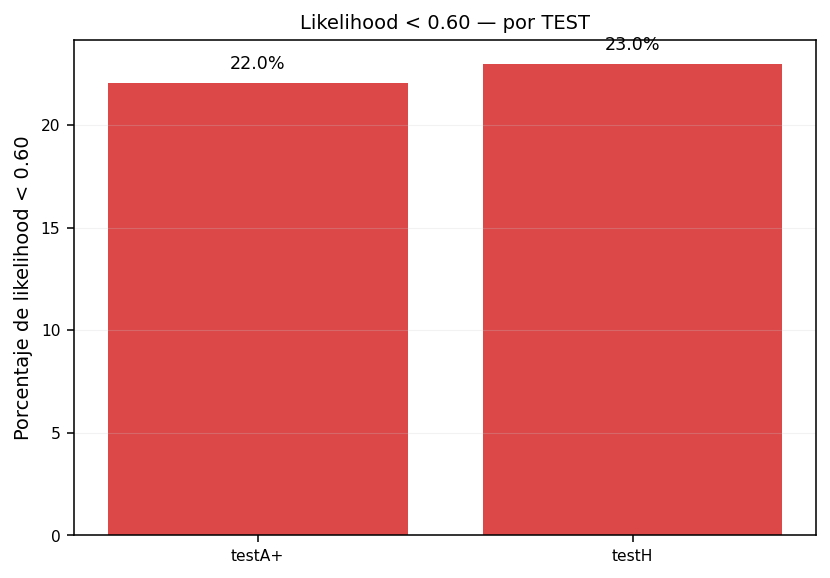

In [25]:
# %% =================== Configuración ===================
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Carpeta con tus .h5 de DLC
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# Umbral de calidad de tracking
LIK_THRESHOLD = 0.6

# Bodyparts a considerar; si alguno no está, se ignora; si ninguno aparece,
# se usan todos los bodyparts disponibles con 'likelihood'
TARGET_BPS = ["al1", "ar1"]

# Guardar CSVs
SAVE_CSV = True
CSV_TRIALS = "likelihood_bajo_por_trial.csv"
CSV_TESTS  = "likelihood_bajo_por_test.csv"

# =================== Utilidades ===================
def natural_key(s):
    # Orden natural: trial2 < trial10, testA < testH, etc.
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', str(s))]

def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    # Intentos típicos de claves DLC
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

# Extrae el prefijo trial/test del nombre (sin depender del resto)
# Ejemplos válidos:
#   trial1_abeja(3).h5
#   testA_abeja(7)_DLC_resnet50_...h5
#   trial1_abeja0DLC_Resnet50_...h5
NAME_RE = re.compile(r"^(?P<prefix>(?:trial|test)[^_]*)_", re.IGNORECASE)

def get_group_from_filename(path: Path) -> str:
    stem = path.stem
    m = NAME_RE.match(stem)
    if m:
        return m.group("prefix")
    # fallback: si no matchea, devuelve el stem completo
    return stem

def collect_likelihood_arrays(df: pd.DataFrame, target_bps=None):
    """
    Devuelve lista de arrays de likelihood (np.ndarray) para los bodyparts seleccionados.
    Si target_bps es None o ninguno aparece, usa TODOS los likelihood disponibles.
    """
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")

    cols = df.columns
    names = cols.names
    # Posibles nombres de niveles
    try:
        idx_bp = names.index("bodyparts")
        idx_coord = names.index("coords")
    except ValueError:
        # fallback a posiciones típicas (scorer, bodyparts, coords)
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)

    # Recolectar todos los likelihood por bodypart
    all_bp_lik = {}  # bp -> np.ndarray
    for c in cols:
        if idx_bp is None or idx_coord is None or len(c) <= max(idx_bp, idx_coord):
            continue
        bp = c[idx_bp]
        coord = c[idx_coord]
        if str(coord).lower() == "likelihood":
            try:
                arr = df.loc[:, c].astype(float).to_numpy()
                all_bp_lik[bp] = arr
            except Exception:
                pass

    if not all_bp_lik:
        return []

    arrs = []
    if target_bps:
        for bp in target_bps:
            if bp in all_bp_lik:
                arrs.append(all_bp_lik[bp])
        if arrs:  # si al menos uno apareció, usar esos
            return arrs

    # Si no hubo coincidencias con TARGET_BPS, usar todos los disponibles
    return list(all_bp_lik.values())

# =================== Agregación ===================
# Por grupo (trialX o testY): contadores de < thr y total
counts = defaultdict(lambda: {"below": 0, "total": 0, "n_files": 0})

h5_files = sorted(FOLDER.glob("*.h5"), key=lambda p: natural_key(p.name))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

skipped = 0
for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        skipped += 1
        continue

    group = get_group_from_filename(h5)
    # Asegurar formato consistente (lower para decidir tipo)
    group_lower = group.lower()

    # Recolectar likelihoods a considerar
    arrs = collect_likelihood_arrays(df, target_bps=TARGET_BPS)
    if not arrs:
        print(f"[WARN] {h5.name}: sin columnas 'likelihood' identificables.")
        continue

    # Concatenar todos los likelihood seleccionados de este archivo
    lk = np.concatenate([a[np.isfinite(a)] for a in arrs if a is not None])
    if lk.size == 0:
        continue

    below = int(np.count_nonzero(lk < LIK_THRESHOLD))
    total = int(lk.size)

    counts[group]["below"] += below
    counts[group]["total"] += total
    counts[group]["n_files"] += 1

# =================== Tablas de salida ===================
rows = []
for grp, d in counts.items():
    total = d["total"]
    pct = (d["below"] / total * 100.0) if total > 0 else np.nan
    kind = "trial" if grp.lower().startswith("trial") else ("test" if grp.lower().startswith("test") else "otro")
    rows.append({
        "group": grp,
        "type": kind,
        "n_files": d["n_files"],
        "n_points": total,
        "n_below": d["below"],
        "pct_below_<%.2f" % LIK_THRESHOLD: pct
    })

df = pd.DataFrame(rows)
if df.empty:
    raise SystemExit("No se construyó ninguna fila de resultados.")

# Separar por tipo y ordenar
df_trials = (df[df["type"]=="trial"]
             .copy()
             .sort_values(by="group", key=lambda s: s.map(natural_key)))
df_tests  = (df[df["type"]=="test"]
             .copy()
             .sort_values(by="group", key=lambda s: s.map(natural_key)))

print("\n=== Porcentaje de likelihood < %.2f — por TRIAL ===" % LIK_THRESHOLD)
if not df_trials.empty:
    print(df_trials[["group","n_files","n_points","n_below","pct_below_<%.2f" % LIK_THRESHOLD]].to_string(index=False))
else:
    print("(sin trials)")

print("\n=== Porcentaje de likelihood < %.2f — por TEST ===" % LIK_THRESHOLD)
if not df_tests.empty:
    print(df_tests[["group","n_files","n_points","n_below","pct_below_<%.2f" % LIK_THRESHOLD]].to_string(index=False))
else:
    print("(sin tests)")

# =================== Guardar CSV (opcional) ===================
if SAVE_CSV:
    if not df_trials.empty:
        df_trials.to_csv(CSV_TRIALS, index=False)
    if not df_tests.empty:
        df_tests.to_csv(CSV_TESTS, index=False)
    print("\nCSV guardados:",
          CSV_TRIALS if not df_trials.empty else "(no trials)",
          "y",
          CSV_TESTS  if not df_tests.empty else "(no tests)")

# =================== Gráficos ===================
def plot_bars(df_sub, title):
    if df_sub.empty:
        return
    groups = list(df_sub["group"])
    vals = df_sub["pct_below_<%.2f" % LIK_THRESHOLD].to_numpy(float)
    fig, ax = plt.subplots(figsize=(max(6, 0.8*len(groups)+2), 4.2), dpi=140)
    ax.bar(np.arange(len(groups)), vals, color="tab:red", alpha=0.85)
    ax.set_xticks(np.arange(len(groups)), groups, rotation=0)
    ax.set_ylabel("Porcentaje de likelihood < %.2f" % LIK_THRESHOLD)
    ax.set_title(title)
    for i, v in enumerate(vals):
        if np.isfinite(v):
            ax.text(i, v + max(0.5, 0.02*max(vals)), f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    ax.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_bars(df_trials, "Likelihood < %.2f — por TRIAL" % LIK_THRESHOLD)
plot_bars(df_tests,  "Likelihood < %.2f — por TEST"  % LIK_THRESHOLD)

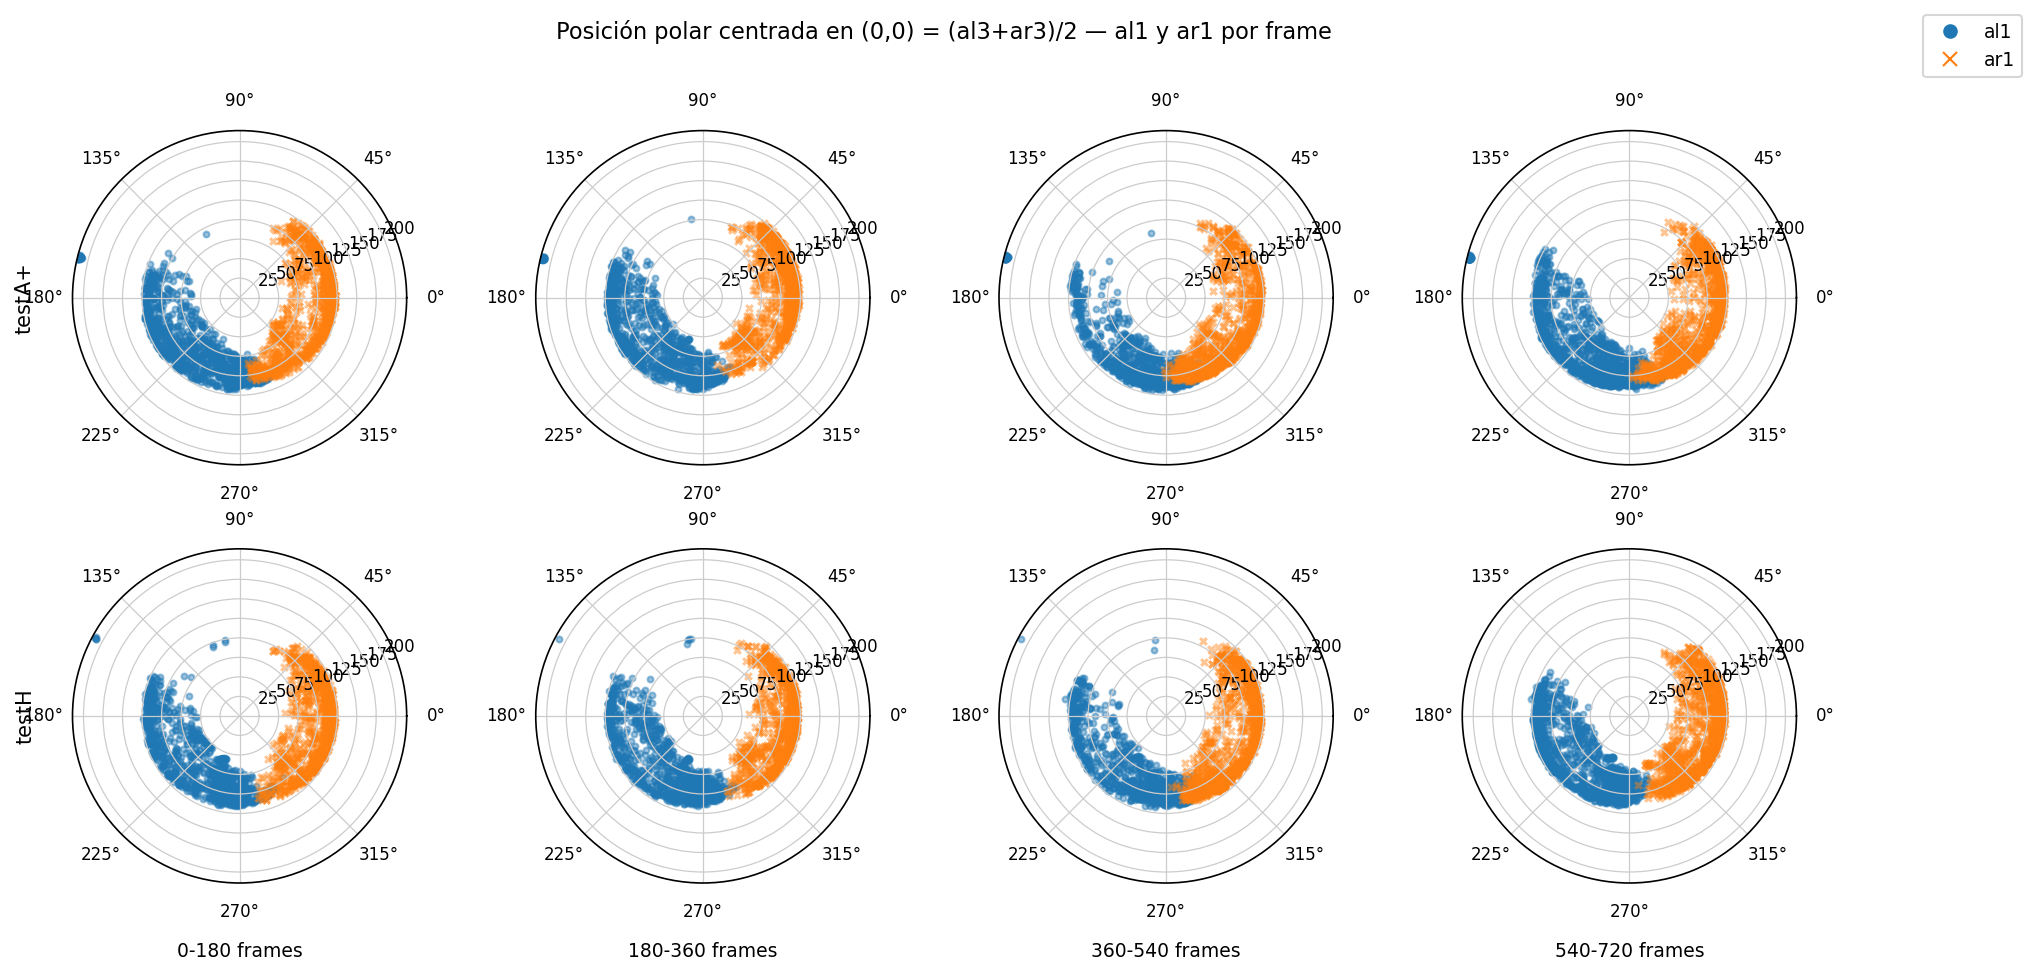

In [ ]:
# %% =================== Configuración ===================
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Carpeta con tus .h5 de DLC
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# Ventanas temporales (frames) como columnas del panel
WINDOWS = [(0, 180), (180, 360), (360, 540), (540, 720)]
#WINDOWS = [(270, 360), (360, 450), (450, 540), (540, 630)]
WINDOW_LABELS = [f"{a}-{b}" for a, b in WINDOWS]

# Sistema de imagen:
INVERT_Y = False     # True si el eje Y del video crece hacia abajo (típico de imágenes)

# Filtrado por likelihood (se exige en puntas y centro)
USE_LIKELIHOOD = True
LIK_THR = 0.8  # estricto: lik > 0.6

# Límite radial común (px) para comparar entre subplots; si None se calcula globalmente
R_MAX = None

# Apariencia del scatter
S_DOTS = 8       # tamaño de los puntos
ALPHA = 0.45     # transparencia

# Colores fijos (puedes cambiarlos si querés)
COLOR_AL1 = "tab:blue"
COLOR_AR1 = "tab:orange"

# Nombre de archivos: trialX/testX + '_' + abeja(n) + opcional extra
FILENAME_RE = re.compile(
    r"^(?P<trialtest>(?:trial|test)[^_]*)_(?P<animal>abeja\(\d+\))(?:_.*)?\.h5$",
    re.IGNORECASE
)

# =================== Utilidades ===================
def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    """Lee un H5 de DLC probando keys comunes; devuelve DataFrame (MultiIndex)."""
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

def get_series(df: pd.DataFrame, bp: str, coord: str) -> np.ndarray:
    """Devuelve el vector para (bp, coord). Espera columnas MultiIndex DLC."""
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")
    cols = df.columns
    names = cols.names
    try:
        idx_bp = names.index("bodyparts"); idx_coord = names.index("coords")
    except ValueError:
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)
    for c in cols:
        if idx_bp is not None and idx_coord is not None and len(c) > max(idx_bp, idx_coord):
            if (c[idx_bp] == bp) and (c[idx_coord] == coord):
                return df.loc[:, c].astype(float).to_numpy()
    raise KeyError(f"No hallé columnas para {bp}-{coord}")

def parse_name(fname: str):
    m = FILENAME_RE.match(fname)
    if m:
        return m.group("trialtest").strip(), m.group("animal")
    return Path(fname).stem, ""

def natural_key(s):
    """Orden 'natural' para trial/test: trial1 < trial2 < test1, etc."""
    import re
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

# =================== Recolectar puntos polares (centrados) ===================
BODYPARTS_TIPS = ("al1", "ar1")
CENTER_BPS = ("al3", "ar3")  # centro = promedio (al3 + ar3)/2

# polar_points[(trial, win_idx, serie)] -> Nx2 con columnas [theta, r]
# serie in {"al1", "ar1"}
polar_points = {}

h5_files = sorted(FOLDER.glob("*.h5"))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        continue

    trial, animal = parse_name(h5.name)

    # -- Centro (al3, ar3) --
    try:
        cx_al3 = get_series(df, CENTER_BPS[0], "x")
        cy_al3 = get_series(df, CENTER_BPS[0], "y")
        cx_ar3 = get_series(df, CENTER_BPS[1], "x")
        cy_ar3 = get_series(df, CENTER_BPS[1], "y")
        lik_al3 = get_series(df, CENTER_BPS[0], "likelihood") if USE_LIKELIHOOD else None
        lik_ar3 = get_series(df, CENTER_BPS[1], "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[SKIP] {h5.name}: centro {CENTER_BPS} faltante ({e})")
        continue

    cxs = 0.5 * (cx_al3 + cx_ar3)  # centro X por frame
    cys = 0.5 * (cy_al3 + cy_ar3)  # centro Y por frame
    if USE_LIKELIHOOD:
        if lik_al3 is None or lik_ar3 is None:
            print(f"[WARN] {h5.name}: likelihood del centro no disponible; no se filtrará por centro.")
            m_center_ok = None
        else:
            m_center_ok = (lik_al3 > LIK_THR) & (lik_ar3 > LIK_THR)
    else:
        m_center_ok = None

    # Puntas
    try:
        x_al1 = get_series(df, "al1", "x"); y_al1 = get_series(df, "al1", "y")
        x_ar1 = get_series(df, "ar1", "x"); y_ar1 = get_series(df, "ar1", "y")
        lik_al1 = get_series(df, "al1", "likelihood") if USE_LIKELIHOOD else None
        lik_ar1 = get_series(df, "ar1", "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[WARN] {h5.name}: puntas faltantes ({e})")
        continue

    n = len(cxs)
    for wi, (a, b) in enumerate(WINDOWS):
        aa = max(0, min(n, a)); bb = max(0, min(n, b))
        if bb - aa <= 0:
            continue

        # recortes
        cx = cxs[aa:bb]; cy = cys[aa:bb]
        al1x = x_al1[aa:bb]; al1y = y_al1[aa:bb]
        ar1x = x_ar1[aa:bb]; ar1y = y_ar1[aa:bb]

        m_valid = np.isfinite(cx) & np.isfinite(cy) & np.isfinite(al1x) & np.isfinite(al1y) & np.isfinite(ar1x) & np.isfinite(ar1y)
        if USE_LIKELIHOOD:
            if lik_al1 is not None: m_valid &= lik_al1[aa:bb] > LIK_THR
            if lik_ar1 is not None: m_valid &= lik_ar1[aa:bb] > LIK_THR
            if m_center_ok is not None: m_valid &= m_center_ok[aa:bb]

        if not np.any(m_valid):
            continue

        # Coordenadas relativas al centro (al3+ar3)/2
        al1_dx = al1x[m_valid] - cx[m_valid]
        al1_dy = al1y[m_valid] - cy[m_valid]
        ar1_dx = ar1x[m_valid] - cx[m_valid]
        ar1_dy = ar1y[m_valid] - cy[m_valid]

        # Si Y crece hacia abajo en la imagen, invertimos Y para ángulos físicos estándar
        if INVERT_Y:
            al1_dy = -al1_dy
            ar1_dy = -ar1_dy

        # A polares
        def to_polar(dx, dy):
            r = np.hypot(dx, dy)
            theta = np.arctan2(dy, dx)  # 0 rad = +X; CCW positivo
            return np.column_stack([theta, r])

        pts_al1 = to_polar(al1_dx, al1_dy)
        pts_ar1 = to_polar(ar1_dx, ar1_dy)

        for serie, pts in (("al1", pts_al1), ("ar1", pts_ar1)):
            key = (trial, wi, serie)
            if key in polar_points:
                polar_points[key] = np.vstack([polar_points[key], pts])
            else:
                polar_points[key] = pts

# --- Trials presentes ---
trials = sorted({k[0] for k in polar_points.keys()}, key=natural_key)
if not trials:
    raise SystemExit("No hay puntos válidos para graficar.")

# --- Radio máximo global para fijar el mismo límite en todos los subplots ---
def compute_global_rmax():
    rmax = 0.0
    for arr in polar_points.values():
        if arr.size == 0: 
            continue
        rmax = max(rmax, float(np.nanmax(arr[:, 1])))
    return rmax if math.isfinite(rmax) and rmax > 0 else 1.0

R_GLOBAL = R_MAX if (R_MAX is not None and R_MAX > 0) else compute_global_rmax()

# =================== Plot: filas=trials, columnas=ventanas (polar) ===================
nrows = len(trials)
ncols = len(WINDOWS)
fig_w = 3.2 * ncols
fig_h = 3.2 * nrows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h),
                         subplot_kw={"projection": "polar"}, squeeze=False)

fig.suptitle("Posición polar centrada en (0,0) = (al3+ar3)/2 — al1 y ar1 por frame", y=0.995)

# Estilos
STYLE = {
    "al1": dict(marker="o", linestyle="None", alpha=ALPHA, s=S_DOTS,  label="al1", color=COLOR_AL1),
    "ar1": dict(marker="x", linestyle="None", alpha=ALPHA, s=S_DOTS+2,label="ar1", color=COLOR_AR1),
}

for i, tr in enumerate(trials):
    for j, (win, wlab) in enumerate(zip(WINDOWS, WINDOW_LABELS)):
        ax = axes[i, j]

        # Extrae puntos
        pts_al1 = polar_points.get((tr, j, "al1"))
        pts_ar1 = polar_points.get((tr, j, "ar1"))

        # Limites y formato polar
        ax.set_rlim(0, R_GLOBAL)
        ax.set_theta_zero_location("E")  # 0 rad a la derecha (eje +X)
        ax.set_theta_direction(1)        # CCW positivo (estándar matemático)

        # Scatters: un punto por frame
        if pts_al1 is not None and pts_al1.size:
            ax.scatter(pts_al1[:, 0], pts_al1[:, 1], **STYLE["al1"])
        if pts_ar1 is not None and pts_ar1.size:
            ax.scatter(pts_ar1[:, 0], pts_ar1[:, 1], **STYLE["ar1"])

        # Etiquetas de filas/columnas
        if j == 0:
            ax.set_ylabel(tr, fontsize=10, labelpad=18)
        if i == nrows - 1:
            ax.set_xlabel(f"{wlab} frames", fontsize=9, labelpad=10)

        # Ticks más limpios
        ax.tick_params(labelsize=8)

# Leyenda global (una sola)
import matplotlib.lines as mlines
handles = [
    mlines.Line2D([0],[0], marker="o", linestyle="None", color=COLOR_AL1, markersize=6, label="al1"),
    mlines.Line2D([0],[0], marker="x", linestyle="None", color=COLOR_AR1, markersize=7, label="ar1"),
]
fig.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.01, 1.00), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()


SVG guardado en: C:\Users\agust\Desktop\panel_polar_heatmap.svg


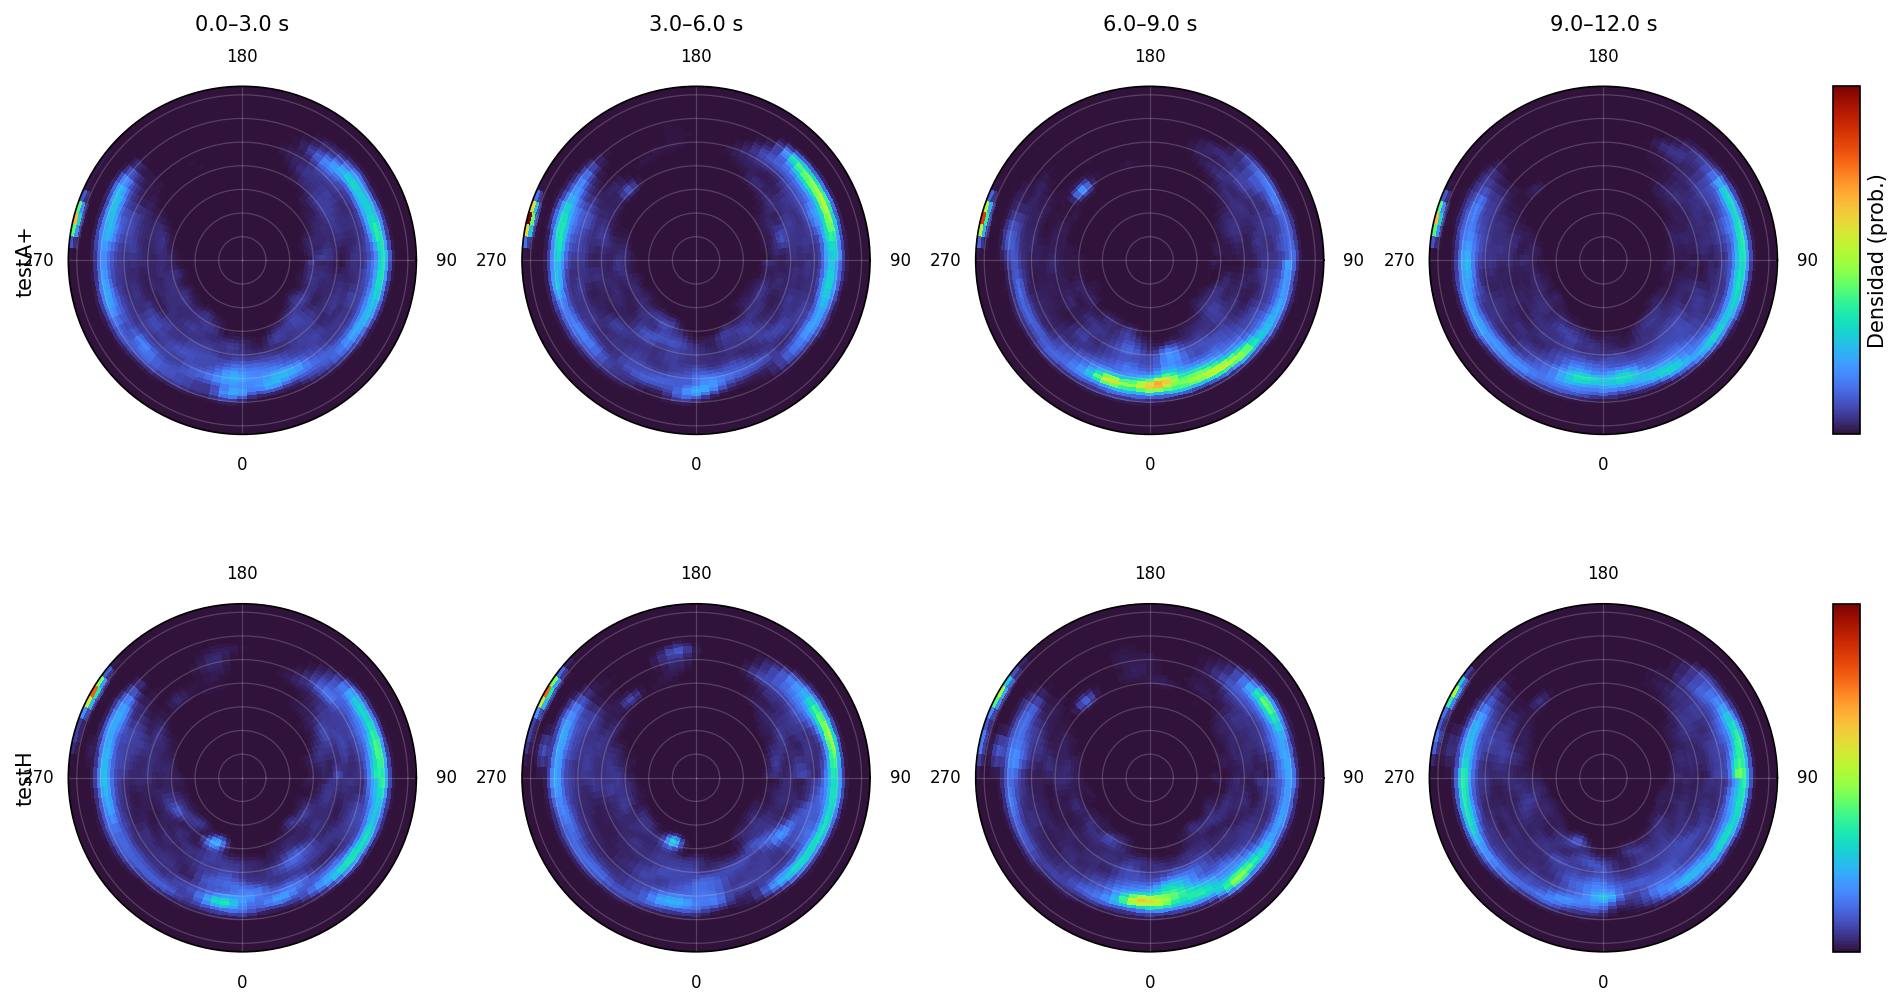

In [23]:
# %% =================== Configuración “paper-ready” con export a SVG en Escritorio ===================
from pathlib import Path
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

# ---------- Estilo general ----------
mpl.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "svg.fonttype": "none",   # <-- texto editable en Illustrator/Inkscape
    "axes.linewidth": 0.8,
    "grid.color": "#cccccc",
    "grid.linewidth": 0.6,
})

# --------- Helper: detectar Escritorio en Windows (Desktop/Escritorio; OneDrive o local) ---------
def get_desktop_path() -> Path:
    candidates = [
        Path.home() / "Desktop",
        Path(os.environ.get("USERPROFILE", "")) / "Desktop",
        Path(os.environ.get("OneDrive", "")) / "Desktop",
        Path.home() / "Escritorio",
        Path(os.environ.get("OneDrive", "")) / "Escritorio",
    ]
    for p in candidates:
        try:
            if p and p.exists():
                return p
        except Exception:
            continue
    return Path.home()

OUT_SVG = get_desktop_path() / "panel_polar_heatmap.svg"

# Carpeta con tus .h5 de DLC
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# --- Ventanas temporales EN FRAMES (para indexar) ---
WINDOWS = [(0, 180), (180, 360), (360, 540), (540, 720)]
FPS = 60
WINDOWS_FRAMES = WINDOWS  # <-- Usamos WINDOWS como WINDOWS_FRAMES
WINDOW_LABELS = [f"{a/FPS:.1f}–{b/FPS:.1f} s" for (a, b) in WINDOWS_FRAMES]

# Sistema de imagen:
INVERT_Y = False     # True si el eje Y del video crece hacia abajo

# Filtrado por likelihood (se exige en puntas y centro)
USE_LIKELIHOOD = True
LIK_THR = 0.6

# ====== ZOOM RADIAL (para ocupar más área; puede recortar bordes) ======
RADIAL_ZOOM_MODE = "global_q"  # "global_q", "row_q" o "global_max"
RADIAL_Q = 0.99
RADIAL_PAD = 0.70
R_MAX = None

# ====== HEATMAP ======
NBINS_THETA = 90
NBINS_R = 50
SMOOTH_SIGMA_POLAR = 1.0     # suavizado gaussiano en bins (None/<=0 desactiva)
DRAW_HEATMAP = True
HEAT_SOURCE = "both"         # 'al1', 'ar1' o 'both'
HEAT_USE_PROB = True         # True=prob. (suma=1) / False=conteo
HEAT_CLIP_PCT = 2.0
CMAP_HEAT = "turbo"
HEAT_GLOBAL_NORM = True
DRAW_SCATTER = False
SHADING = "flat"

# ====== Etiquetas angulares (solo rótulos, no datos) ======
THETA_ZERO_LABEL_AT_DEG = 270
THETA_TICK_STEP_DEG = 90

# Nombre de archivos: trialX/testX + '_' + abeja(n) + opcional extra
FILENAME_RE = re.compile(
    r"^(?P<trialtest>(?:trial|test)[^_]*)_(?P<animal>abeja\(\d+\))(?:_.*)?\.h5$",
    re.IGNORECASE
)

# =================== Utilidades ===================
def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

def get_series(df: pd.DataFrame, bp: str, coord: str) -> np.ndarray:
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")
    cols = df.columns
    names = cols.names
    try:
        idx_bp = names.index("bodyparts"); idx_coord = names.index("coords")
    except ValueError:
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)
    for c in cols:
        if idx_bp is not None and idx_coord is not None and len(c) > max(idx_bp, idx_coord):
            if (c[idx_bp] == bp) and (c[idx_coord] == coord):
                return df.loc[:, c].astype(float).to_numpy()
    raise KeyError(f"No hallé columnas para {bp}-{coord}")

def parse_name(fname: str):
    m = FILENAME_RE.match(fname)
    if m:
        return m.group("trialtest").strip(), m.group("animal")
    return Path(fname).stem, ""

def natural_key(s):
    import re
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def try_gaussian_smooth(img, sigma):
    if sigma is None or sigma <= 0:
        return img
    try:
        from scipy.ndimage import gaussian_filter
        return gaussian_filter(img, sigma=sigma, mode="nearest")
    except Exception:
        return img

def relabel_theta_axis(ax, zero_label_at_deg=270, step_deg=90, show_degree_symbol=False):
    """No rota datos: solo cambia los textos para que 0° aparezca en `zero_label_at_deg`."""
    angles = np.arange(0, 360, step_deg)
    labels = (angles - zero_label_at_deg) % 360
    lab_txt = [f"{int(v)}" + ("°" if show_degree_symbol else "") for v in labels]
    ax.set_thetagrids(angles, labels=lab_txt)

# =================== Recolectar puntos polares (centrados) ===================
CENTER_BPS = ("al3", "ar3")  # centro = promedio (al3 + ar3)/2
polar_points = {}            # (trial, win_idx, serie) -> Nx2 [theta, r]

h5_files = sorted(FOLDER.glob("*.h5"))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        continue

    trial, animal = parse_name(h5.name)

    # Centro (al3, ar3)
    try:
        cx_al3 = get_series(df, CENTER_BPS[0], "x")
        cy_al3 = get_series(df, CENTER_BPS[0], "y")
        cx_ar3 = get_series(df, CENTER_BPS[1], "x")
        cy_ar3 = get_series(df, CENTER_BPS[1], "y")
        lik_al3 = get_series(df, CENTER_BPS[0], "likelihood") if USE_LIKELIHOOD else None
        lik_ar3 = get_series(df, CENTER_BPS[1], "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[SKIP] {h5.name}: centro {CENTER_BPS} faltante ({e})")
        continue

    cxs = 0.5 * (cx_al3 + cx_ar3)
    cys = 0.5 * (cy_al3 + cy_ar3)
    if USE_LIKELIHOOD:
        if lik_al3 is None or lik_ar3 is None:
            print(f"[WARN] {h5.name}: likelihood del centro no disponible; no se filtrará por centro.")
            m_center_ok = None
        else:
            m_center_ok = (lik_al3 > LIK_THR) & (lik_ar3 > LIK_THR)
    else:
        m_center_ok = None

    # Puntas
    try:
        x_al1 = get_series(df, "al1", "x"); y_al1 = get_series(df, "al1", "y")
        x_ar1 = get_series(df, "ar1", "x"); y_ar1 = get_series(df, "ar1", "y")
        lik_al1 = get_series(df, "al1", "likelihood") if USE_LIKELIHOOD else None
        lik_ar1 = get_series(df, "ar1", "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[WARN] {h5.name}: puntas faltantes ({e})")
        continue

    n = len(cxs)
    for wi, (a, b) in enumerate(WINDOWS_FRAMES):
        aa = max(0, min(n, a)); bb = max(0, min(n, b))
        if bb - aa <= 0:
            continue

        cx = cxs[aa:bb]; cy = cys[aa:bb]
        al1x = x_al1[aa:bb]; al1y = y_al1[aa:bb]
        ar1x = x_ar1[aa:bb]; ar1y = y_ar1[aa:bb]

        m_valid = (np.isfinite(cx) & np.isfinite(cy) &
                   np.isfinite(al1x) & np.isfinite(al1y) &
                   np.isfinite(ar1x) & np.isfinite(ar1y))
        if USE_LIKELIHOOD:
            if lik_al1 is not None: m_valid &= lik_al1[aa:bb] > LIK_THR
            if lik_ar1 is not None: m_valid &= lik_ar1[aa:bb] > LIK_THR
            if m_center_ok is not None: m_valid &= m_center_ok[aa:bb]
        if not np.any(m_valid):
            continue

        # Coordenadas relativas al centro
        al1_dx = al1x[m_valid] - cx[m_valid]; al1_dy = al1y[m_valid] - cy[m_valid]
        ar1_dx = ar1x[m_valid] - cx[m_valid]; ar1_dy = ar1y[m_valid] - cy[m_valid]
        if INVERT_Y:
            al1_dy = -al1_dy; ar1_dy = -ar1_dy

        def to_polar(dx, dy):
            r = np.hypot(dx, dy)
            theta = np.arctan2(dy, dx)  # 0 rad = +X; CCW +
            return np.column_stack([theta, r])

        pts_al1 = to_polar(al1_dx, al1_dy)
        pts_ar1 = to_polar(ar1_dx, ar1_dy)

        for serie, pts in (("al1", pts_al1), ("ar1", pts_ar1)):
            key = (trial, wi, serie)
            if key in polar_points:
                polar_points[key] = np.vstack([polar_points[key], pts])
            else:
                polar_points[key] = pts

# --- Trials presentes ---
trials = sorted({k[0] for k in polar_points.keys()}, key=natural_key)
if not trials:
    raise SystemExit("No hay puntos válidos para graficar.")

# ====== Cálculo de límites radiales (zoom robusto) ======
def all_radii_for_trial(tr):
    arrs = [v[:, 1] for (t, _, _), v in polar_points.items() if t == tr and v.size]
    return np.concatenate(arrs) if len(arrs) else np.array([])

def all_radii_global():
    arrs = [v[:, 1] for v in polar_points.values() if v.size]
    return np.concatenate(arrs) if len(arrs) else np.array([])

R_GLOBAL = None
R_ROW = {}

if R_MAX is not None and R_MAX > 0:
    R_GLOBAL = float(R_MAX)
else:
    if RADIAL_ZOOM_MODE == "global_q":
        rr = all_radii_global()
        R_GLOBAL = float(np.nanpercentile(rr, RADIAL_Q * 100.0) * RADIAL_PAD) if rr.size else 1.0
    elif RADIAL_ZOOM_MODE == "row_q":
        for tr in trials:
            rr = all_radii_for_trial(tr)
            R_ROW[tr] = float(np.nanpercentile(rr, RADIAL_Q * 100.0) * RADIAL_PAD) if rr.size else 1.0
    else:  # "global_max"
        rmax = 0.0
        for arr in polar_points.values():
            if arr.size:
                rmax = max(rmax, float(np.nanmax(arr[:, 1])))
        R_GLOBAL = rmax if math.isfinite(rmax) and rmax > 0 else 1.0

# Seguridad
if R_GLOBAL is not None:
    R_GLOBAL = max(R_GLOBAL, 1.0)
for tr in list(R_ROW.keys()):
    R_ROW[tr] = max(R_ROW[tr], 1.0)

# =================== Plot (HEATMAP) ===================
nrows = len(trials)
ncols = len(WINDOWS_FRAMES)

fig_w_per_col = 3.7
fig_h_per_row = 3.7
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=(fig_w_per_col*ncols, fig_h_per_row*nrows),
                         subplot_kw={"projection": "polar"}, squeeze=False)

# Fondo blanco y grilla suave
for ax in axes.ravel():
    ax.set_facecolor("white")
    ax.grid(True, alpha=0.25)

# Títulos por columna (en segundos)
for j, wlab in enumerate(WINDOW_LABELS):
    axes[0, j].set_title(wlab, pad=8)

theta_edges_global = np.linspace(0.0, 2*np.pi, NBINS_THETA + 1)

pcms_grid = [[None for _ in range(ncols)] for _ in range(nrows)]
global_max = 0.0

for i, tr in enumerate(trials):
    for j, (win, wlab) in enumerate(zip(WINDOWS_FRAMES, WINDOW_LABELS)):
        ax = axes[i, j]

        # rmax local según modo
        if RADIAL_ZOOM_MODE == "row_q" and tr in R_ROW:
            rmax = R_ROW[tr]
        else:
            rmax = R_GLOBAL if R_GLOBAL is not None else 1.0

        ax.set_rlim(0, rmax)
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(1)

        # Ticks angulares rotulados (0° donde estaba 270°)
        relabel_theta_axis(ax, zero_label_at_deg=THETA_ZERO_LABEL_AT_DEG,
                           step_deg=THETA_TICK_STEP_DEG, show_degree_symbol=False)

        # Ocultar etiquetas radiales
        for lab in ax.get_yticklabels():
            lab.set_visible(False)
        ax.set_rlabel_position(135)

        # Datos
        pts_al1 = polar_points.get((tr, j, "al1"))
        pts_ar1 = polar_points.get((tr, j, "ar1"))

        thetas_list = []; rs_list = []
        if HEAT_SOURCE in ("al1", "both") and (pts_al1 is not None and pts_al1.size):
            thetas_list.append(np.mod(pts_al1[:, 0], 2*np.pi))
            rs_list.append(np.clip(pts_al1[:, 1], 0, rmax))
        if HEAT_SOURCE in ("ar1", "both") and (pts_ar1 is not None and pts_ar1.size):
            thetas_list.append(np.mod(pts_ar1[:, 0], 2*np.pi))
            rs_list.append(np.clip(pts_ar1[:, 1], 0, rmax))
        if not thetas_list:
            continue

        thetas = np.concatenate(thetas_list)
        rs = np.concatenate(rs_list)

        r_edges = np.linspace(0.0, rmax, NBINS_R + 1)
        H, _, _ = np.histogram2d(thetas, rs,
                                 bins=[theta_edges_global, r_edges],
                                 range=[(0.0, 2*np.pi), (0.0, rmax)])
        H = H.T

        # Probabilidad vs conteo
        if HEAT_USE_PROB:
            s = H.sum()
            P = (H / s) if s > 0 else H.astype(float)
        else:
            P = H.astype(float)

        # Suavizado
        if SMOOTH_SIGMA_POLAR and SMOOTH_SIGMA_POLAR > 0:
            P = try_gaussian_smooth(P, SMOOTH_SIGMA_POLAR)

        # Clip bajo para limpiar ruido
        if HEAT_CLIP_PCT and HEAT_CLIP_PCT > 0:
            vals = P[P > 0]
            if vals.size:
                thr = np.percentile(vals, HEAT_CLIP_PCT)
                P[P < thr] = 0.0

        if np.isfinite(P).any():
            global_max = max(global_max, float(np.nanmax(P)))

        # Dibujar heatmap
        pcm = ax.pcolormesh(theta_edges_global, r_edges, P,
                            cmap=CMAP_HEAT, shading=SHADING, zorder=1)
        pcms_grid[i][j] = pcm

        # Overlay de puntos (opcional)
        if DRAW_SCATTER:
            if pts_al1 is not None and pts_al1.size and HEAT_SOURCE in ("al1", "both"):
                ax.scatter(pts_al1[:, 0], pts_al1[:, 1], marker="o", s=10, alpha=0.35, color="tab:blue", zorder=2, rasterized=True)
            if pts_ar1 is not None and pts_ar1.size and HEAT_SOURCE in ("ar1", "both"):
                ax.scatter(pts_ar1[:, 0], pts_ar1[:, 1], marker="x", s=12, alpha=0.35, color="tab:orange", zorder=2, rasterized=True)

        if j == 0:
            ax.set_ylabel(tr, fontsize=10, labelpad=16)
        ax.tick_params(pad=4)

# ===== Normalización global =====
import matplotlib.colors as mcolors
norm = None
if HEAT_GLOBAL_NORM and global_max > 0:
    norm = mcolors.Normalize(vmin=0.0, vmax=global_max)
    for i in range(nrows):
        for j in range(ncols):
            pcm = pcms_grid[i][j]
            if pcm is not None:
                pcm.set_norm(norm)

# ===== Colorbars por fila: sin valores y más a la derecha =====
right_margin = 0.84  # deja 16% del ancho para barras y respiración
plt.tight_layout(rect=[0.0, 0.0, right_margin, 0.98])
plt.draw()

gap = 0.025   # espacio entre última columna y colorbar
cbar_w = 0.012

for i in range(nrows):
    row_axes = [axes[i, j] for j in range(ncols) if pcms_grid[i][j] is not None]
    if not row_axes:
        continue
    poss = [ax.get_position() for ax in row_axes]
    left   = min(p.x0 for p in poss)
    right  = max(p.x1 for p in poss)
    bottom = min(p.y0 for p in poss)
    top    = max(p.y1 for p in poss)

    if right > right_margin - (gap + cbar_w):
        scale = (right_margin - (gap + cbar_w) - left) / (right - left)
        for ax in row_axes:
            p = ax.get_position()
            new_left = left + (p.x0 - left) * scale
            new_right = left + (p.x1 - left) * scale
            ax.set_position([new_left, p.y0, new_right - new_left, p.height])
        poss = [ax.get_position() for ax in row_axes]
        right  = max(p.x1 for p in poss)
        bottom = min(p.y0 for p in poss)
        top    = max(p.y1 for p in poss)

    cax_left = right + gap
    cax = plt.gcf().add_axes([cax_left, bottom, cbar_w, top - bottom])

    row_mappable = next(pcms_grid[i][j] for j in range(ncols) if pcms_grid[i][j] is not None)
    cbar = plt.gcf().colorbar(row_mappable, cax=cax)

    # Sin valores/ticks en la barra de color
    cbar.set_ticks([])
    cbar.ax.tick_params(length=0)

    if i == 0:
        cbar.set_label("Densidad (prob.)" if HEAT_USE_PROB else "Conteo", rotation=90)

# ======= Exportar a SVG en el Escritorio =======
# Usamos bbox_inches="tight" para evitar recortes y pad pequeño; fondo blanco (transparent=False)
plt.savefig(OUT_SVG, format="svg", bbox_inches="tight", pad_inches=0.01, transparent=False)
print(f"SVG guardado en: {OUT_SVG}")

plt.show()


In [12]:
# %% =================== Configuración “paper-ready” ===================
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

# ---------- Ajustes de figura para publicación ----------
mpl.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,   # Texto como texto en PDF
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
    "grid.color": "#cccccc",
    "grid.linewidth": 0.6,
})

# Carpeta con tus .h5 de DLC
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# --- Ventanas temporales EN FRAMES (para indexar) ---
WINDOWS_FRAMES = [(0, 180), (180, 360), (360, 540), (540, 720)]
# WINDOWS_FRAMES = [(270, 360), (360, 450), (450, 540), (540, 630)]

# --- Conversión a segundos para rótulos (no altera el slicing) ---
FPS = 60
WINDOW_LABELS = [f"{a/FPS:.1f}–{b/FPS:.1f} s" for (a, b) in WINDOWS_FRAMES]

# Sistema de imagen:
INVERT_Y = False     # True si el eje Y del video crece hacia abajo

# Filtrado por likelihood (se exige en puntas y centro)
USE_LIKELIHOOD = True
LIK_THR = 0.6

# ====== ZOOM RADIAL (para que los datos ocupen más área) ======
# Opciones: "global_q" (recomendado), "row_q", "global_max"
RADIAL_ZOOM_MODE = "global_q"
RADIAL_Q = 0.98       # percentil para r (0-1)
RADIAL_PAD = 1.05     # margen extra sobre el percentil
R_MAX = None          # si lo pones en número, se usa ese valor fijo y se ignora el modo

# Apariencia del scatter (paper-friendly)
S_DOTS = 14        # puntos más grandes
ALPHA = 0.40

# Colores fijos para puntos
COLOR_AL1 = "tab:blue"
COLOR_AR1 = "tab:orange"

# ====== Contornos de presencia (HDR en histograma polar) ======
DRAW_CONTOURS = True
CONTOUR_LEVEL_FRACS = [0.5, 0.7, 0.9]  # 50%, 70%, 90%
NBINS_THETA = 72
NBINS_R = 40
SMOOTH_SIGMA_POLAR = 1.0

# Colores por nivel HDR (50% azul, 70% rojo, 90% negro)
FRAC_COLORS = {0.5: "blue", 0.7: "red", 0.9: "black"}

# Exports (opcional)
SAVE_STEM = None  # p.ej. "polar_HDR_grid"
# SAVE_STEM = "polar_HDR_grid"

# Nombre de archivos: trialX/testX + '_' + abeja(n) + opcional extra
FILENAME_RE = re.compile(
    r"^(?P<trialtest>(?:trial|test)[^_]*)_(?P<animal>abeja\(\d+\))(?:_.*)?\.h5$",
    re.IGNORECASE
)

# =================== Utilidades ===================
def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

def get_series(df: pd.DataFrame, bp: str, coord: str) -> np.ndarray:
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")
    cols = df.columns
    names = cols.names
    try:
        idx_bp = names.index("bodyparts"); idx_coord = names.index("coords")
    except ValueError:
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)
    for c in cols:
        if idx_bp is not None and idx_coord is not None and len(c) > max(idx_bp, idx_coord):
            if (c[idx_bp] == bp) and (c[idx_coord] == coord):
                return df.loc[:, c].astype(float).to_numpy()
    raise KeyError(f"No hallé columnas para {bp}-{coord}")

def parse_name(fname: str):
    m = FILENAME_RE.match(fname)
    if m:
        return m.group("trialtest").strip(), m.group("animal")
    return Path(fname).stem, ""

def natural_key(s):
    import re
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def try_gaussian_smooth(img, sigma):
    if sigma is None or sigma <= 0:
        return img
    try:
        from scipy.ndimage import gaussian_filter
        return gaussian_filter(img, sigma=sigma, mode="nearest")
    except Exception:
        return img

def hdr_thresholds(P, fracs):
    """Umbrales de densidad tales que {P >= t} contiene ~f de la masa."""
    P = np.asarray(P, dtype=float)
    s = P.sum()
    if not np.isfinite(s) or s <= 0:
        return [np.nan for _ in fracs]
    Pn = P / s
    v = np.sort(Pn.ravel())[::-1]
    c = np.cumsum(v)
    out = []
    for f in fracs:
        f = float(np.clip(f, 0.0, 1.0))
        idx = np.searchsorted(c, f, side="left")
        idx = min(idx, len(v) - 1)
        out.append(v[idx])
    return out

# =================== Recolectar puntos polares (centrados) ===================
CENTER_BPS = ("al3", "ar3")  # centro = promedio (al3 + ar3)/2

# polar_points[(trial, win_idx, serie)] -> Nx2 con columnas [theta, r]
polar_points = {}

h5_files = sorted(FOLDER.glob("*.h5"))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        continue

    trial, animal = parse_name(h5.name)

    # Centro (al3, ar3)
    try:
        cx_al3 = get_series(df, CENTER_BPS[0], "x")
        cy_al3 = get_series(df, CENTER_BPS[0], "y")
        cx_ar3 = get_series(df, CENTER_BPS[1], "x")
        cy_ar3 = get_series(df, CENTER_BPS[1], "y")
        lik_al3 = get_series(df, CENTER_BPS[0], "likelihood") if USE_LIKELIHOOD else None
        lik_ar3 = get_series(df, CENTER_BPS[1], "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[SKIP] {h5.name}: centro {CENTER_BPS} faltante ({e})")
        continue

    cxs = 0.5 * (cx_al3 + cx_ar3)
    cys = 0.5 * (cy_al3 + cy_ar3)
    if USE_LIKELIHOOD:
        if lik_al3 is None or lik_ar3 is None:
            print(f"[WARN] {h5.name}: likelihood del centro no disponible; no se filtrará por centro.")
            m_center_ok = None
        else:
            m_center_ok = (lik_al3 > LIK_THR) & (lik_ar3 > LIK_THR)
    else:
        m_center_ok = None

    # Puntas
    try:
        x_al1 = get_series(df, "al1", "x"); y_al1 = get_series(df, "al1", "y")
        x_ar1 = get_series(df, "ar1", "x"); y_ar1 = get_series(df, "ar1", "y")
        lik_al1 = get_series(df, "al1", "likelihood") if USE_LIKELIHOOD else None
        lik_ar1 = get_series(df, "ar1", "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[WARN] {h5.name}: puntas faltantes ({e})")
        continue

    n = len(cxs)
    for wi, (a, b) in enumerate(WINDOWS_FRAMES):
        aa = max(0, min(n, a)); bb = max(0, min(n, b))
        if bb - aa <= 0:
            continue

        cx = cxs[aa:bb]; cy = cys[aa:bb]
        al1x = x_al1[aa:bb]; al1y = y_al1[aa:bb]
        ar1x = x_ar1[aa:bb]; ar1y = y_ar1[aa:bb]

        m_valid = np.isfinite(cx) & np.isfinite(cy) & np.isfinite(al1x) & np.isfinite(al1y) & np.isfinite(ar1x) & np.isfinite(ar1y)
        if USE_LIKELIHOOD:
            if lik_al1 is not None: m_valid &= lik_al1[aa:bb] > LIK_THR
            if lik_ar1 is not None: m_valid &= lik_ar1[aa:bb] > LIK_THR
            if m_center_ok is not None: m_valid &= m_center_ok[aa:bb]
        if not np.any(m_valid):
            continue

        # Coordenadas relativas al centro
        al1_dx = al1x[m_valid] - cx[m_valid]; al1_dy = y_al1[m_valid] - cy[m_valid]
        ar1_dx = ar1x[m_valid] - cx[m_valid]; ar1_dy = y_ar1[m_valid] - cy[m_valid]
        if INVERT_Y:
            al1_dy = -al1_dy; ar1_dy = -ar1_dy

        def to_polar(dx, dy):
            r = np.hypot(dx, dy)
            theta = np.arctan2(dy, dx)  # 0 rad = +X; CCW +
            return np.column_stack([theta, r])

        pts_al1 = to_polar(al1_dx, al1_dy)
        pts_ar1 = to_polar(ar1_dx, ar1_dy)

        for serie, pts in (("al1", pts_al1), ("ar1", pts_ar1)):
            key = (trial, wi, serie)
            if key in polar_points:
                polar_points[key] = np.vstack([polar_points[key], pts])
            else:
                polar_points[key] = pts

# --- Trials presentes ---
trials = sorted({k[0] for k in polar_points.keys()}, key=natural_key)
if not trials:
    raise SystemExit("No hay puntos válidos para graficar.")

# ====== Calcular límites radiales robustos ======
def all_radii_for_trial(tr):
    arrs = [v[:, 1] for (t, _, _), v in polar_points.items() if t == tr and v.size]
    return np.concatenate(arrs) if len(arrs) else np.array([])

def all_radii_global():
    arrs = [v[:, 1] for v in polar_points.values() if v.size]
    return np.concatenate(arrs) if len(arrs) else np.array([])

R_GLOBAL = None
R_ROW = {}

if R_MAX is not None and R_MAX > 0:
    R_GLOBAL = float(R_MAX)
else:
    if RADIAL_ZOOM_MODE == "global_q":
        rr = all_radii_global()
        if rr.size:
            R_GLOBAL = float(np.nanpercentile(rr, RADIAL_Q * 100.0)) * RADIAL_PAD
        else:
            R_GLOBAL = 1.0
    elif RADIAL_ZOOM_MODE == "row_q":
        for tr in trials:
            rr = all_radii_for_trial(tr)
            R_ROW[tr] = (float(np.nanpercentile(rr, RADIAL_Q * 100.0)) * RADIAL_PAD) if rr.size else 1.0
    else:  # "global_max"
        def compute_global_rmax():
            rmax = 0.0
            for arr in polar_points.values():
                if arr.size == 0:
                    continue
                rmax = max(rmax, float(np.nanmax(arr[:, 1])))
            return rmax if math.isfinite(rmax) and rmax > 0 else 1.0
        R_GLOBAL = compute_global_rmax()

# Seguridad por si el percentil es muy chico
if R_GLOBAL is not None:
    R_GLOBAL = max(R_GLOBAL, 1.0)
for tr in list(R_ROW.keys()):
    R_ROW[tr] = max(R_ROW[tr], 1.0)

# =================== Plot ===================
nrows = len(trials)
ncols = len(WINDOWS_FRAMES)

# Un poco más grande
fig_w_per_col = 3.7
fig_h_per_row = 3.7
fig_w = fig_w_per_col * ncols
fig_h = fig_h_per_row * nrows

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h),
                         subplot_kw={"projection": "polar"}, squeeze=False)

# Estilos de puntos (rasterized=True para SVG/PDF liviano)
STYLE_SCATTER = {
    "al1": dict(marker="o", linestyle="None", alpha=ALPHA, s=S_DOTS,
                color=COLOR_AL1, label="al1", rasterized=True),
    "ar1": dict(marker="x", linestyle="None", alpha=ALPHA, s=S_DOTS+2,
                color=COLOR_AR1, label="ar1", rasterized=True),
}

# Títulos por columna (en segundos)
for j, wlab in enumerate(WINDOW_LABELS):
    axes[0, j].set_title(wlab, pad=8)

# --- Etiquetas angulares rotadas SIN mover datos ---
ANGLES_DEG = [0, 90, 180, 270]
LABELS_DEG = [f"{(a + 90) % 360}°" for a in ANGLES_DEG]  # 270 → 0, 0 → 90, etc.

for i, tr in enumerate(trials):
    for j in range(ncols):
        ax = axes[i, j]

        pts_al1 = polar_points.get((tr, j, "al1"))
        pts_ar1 = polar_points.get((tr, j, "ar1"))

        # Límite radial (modo elegido)
        if RADIAL_ZOOM_MODE == "row_q" and tr in R_ROW:
            rmax = R_ROW[tr]
        else:
            rmax = R_GLOBAL if R_GLOBAL is not None else 1.0

        ax.set_rlim(0, rmax)
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(1)

        # Grilla sutil
        ax.grid(True, alpha=0.6)

        # Rotación SOLO de etiquetas angulares
        ax.set_thetagrids(ANGLES_DEG, labels=LABELS_DEG)

        # Ocultar etiquetas radiales, conservar grilla
        for lab in ax.get_yticklabels():
            lab.set_visible(False)
        ax.set_rlabel_position(135)

        # Puntos
        if pts_al1 is not None and pts_al1.size:
            ax.scatter(pts_al1[:, 0], pts_al1[:, 1], **STYLE_SCATTER["al1"], zorder=2)
        if pts_ar1 is not None and pts_ar1.size:
            ax.scatter(pts_ar1[:, 0], pts_ar1[:, 1], **STYLE_SCATTER["ar1"], zorder=2)

        # ===== Contornos HDR =====
        if DRAW_CONTOURS:
            theta_edges = np.linspace(0.0, 2*np.pi, NBINS_THETA + 1)
            r_edges = np.linspace(0.0, rmax, NBINS_R + 1)  # usar rmax local
            theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
            r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
            TH, RR = np.meshgrid(theta_centers, r_centers)  # (n_r, n_theta)

            def draw_hdr_contours(pts, linestyle):
                if pts is None or pts.size == 0:
                    return
                thetas = np.mod(pts[:, 0], 2*np.pi)
                rs = np.clip(pts[:, 1], 0, rmax)

                H, _, _ = np.histogram2d(thetas, rs,
                                         bins=[theta_edges, r_edges],
                                         range=[(0.0, 2*np.pi), (0.0, rmax)])
                H = H.T
                P = H.astype(float)
                s = P.sum()
                if s <= 0:
                    return
                P /= s
                P = try_gaussian_smooth(P, SMOOTH_SIGMA_POLAR)
                s2 = P.sum()
                if s2 > 0:
                    P /= s2

                target_fracs = np.array(CONTOUR_LEVEL_FRACS, dtype=float)
                raw_levels = hdr_thresholds(P, target_fracs)

                pairs = [(float(f), float(lv)) for f, lv in zip(target_fracs, raw_levels)
                         if np.isfinite(lv) and lv > 0]
                if not pairs:
                    return
                uniq = {}
                for f, lv in pairs:
                    key = round(lv, 12)
                    if key not in uniq:
                        uniq[key] = (f, lv)
                pairs = list(uniq.values())
                pairs.sort(key=lambda t: t[1])

                levels_vals = [lv for (f, lv) in pairs]
                colors = [FRAC_COLORS.get(f, "black") for (f, lv) in pairs]
                lw_map = {0.5: 2.0, 0.7: 1.7, 0.9: 1.5}
                linewidths = [lw_map.get(f, 1.5) for (f, lv) in pairs]
                linestyles = [linestyle] * len(levels_vals)

                ax.contour(TH, RR, P, levels=levels_vals,
                           colors=colors, linewidths=linewidths, linestyles=linestyles,
                           zorder=3, alpha=0.98)

            draw_hdr_contours(pts_al1, "solid")
            draw_hdr_contours(pts_ar1, "dashed")

        # Etiqueta de fila (trial/test) a la izquierda
        if j == 0:
            ax.set_ylabel(tr, fontsize=10, labelpad=14)

        ax.tick_params(pad=4)

# Leyenda global (compacta)
import matplotlib.lines as mlines
handles = [
    mlines.Line2D([0],[0], marker="o", linestyle="None", color=COLOR_AL1, markersize=6, label="al1 (puntos)"),
    mlines.Line2D([0],[0], marker="x", linestyle="None", color=COLOR_AR1, markersize=6, label="ar1 (puntos)"),
    mlines.Line2D([0],[0], linestyle="solid", color="black", label="contornos al1"),
    mlines.Line2D([0],[0], linestyle="dashed", color="black", label="contornos ar1"),
]
fig.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.01, 1.00), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.98, 0.98])

# Guardado opcional
if SAVE_STEM:
    for ext in (".svg", ".pdf", ".png"):
        fig.savefig(f"{SAVE_STEM}{ext}", bbox_inches="tight")
        print(f"Guardado: {SAVE_STEM}{ext}")

plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1487 but corresponding boolean dimension is 180


=== Distancia al1–ar1 por archivo (mean por ventana) ===
              file trialtest   animal  window  n_frames_used  dist_px_mean  dist_px_median  dist_px_std  dist_norm_mean  dist_norm_median  dist_norm_std
testA+_abeja(1).h5    testA+ abeja(1)   0-180            103    188.255664      184.953123    27.618563       13.850777         14.001524       2.305461
testA+_abeja(1).h5    testA+ abeja(1) 180-360            157    194.398736      194.182103    33.611661       14.130606         14.452467       2.779988
testA+_abeja(1).h5    testA+ abeja(1) 360-540            150    115.591440      113.121545    28.612512        7.857982          7.756600       2.175539
testA+_abeja(1).h5    testA+ abeja(1) 540-720            123    155.955987      156.562255    39.673775       11.162727         11.350569       3.059596
testA+_abeja(2).h5    testA+ abeja(2)   0-180            108    116.269014      127.499659    66.893519        7.199070          7.663359       4.096443

Filas: 196   Archivos ú

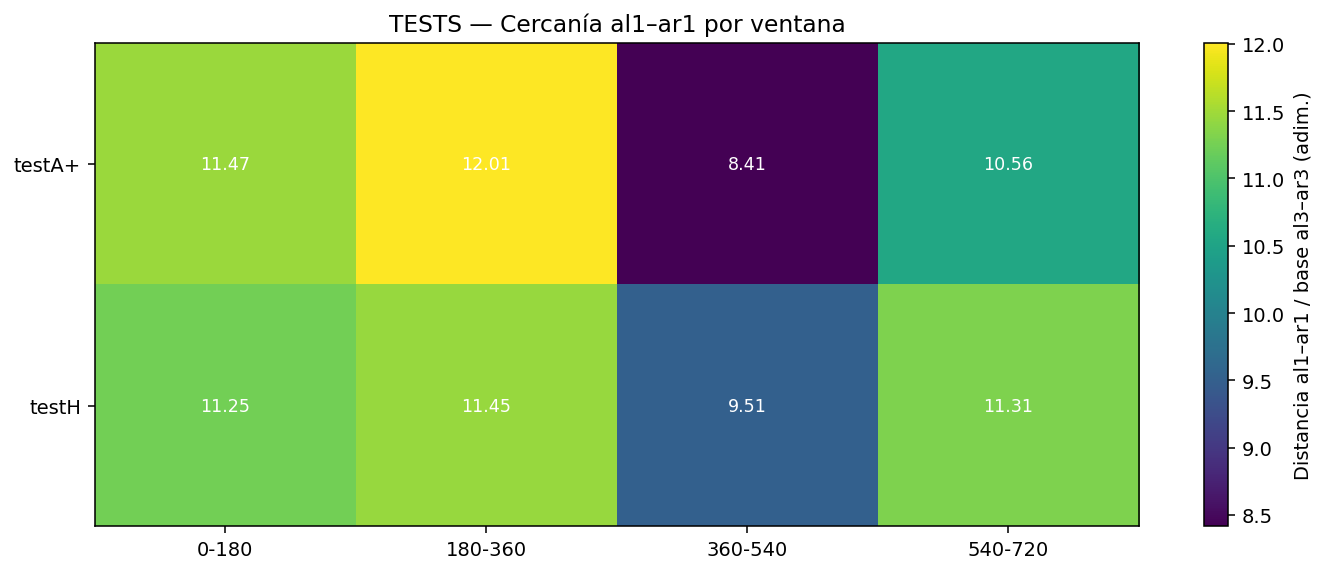

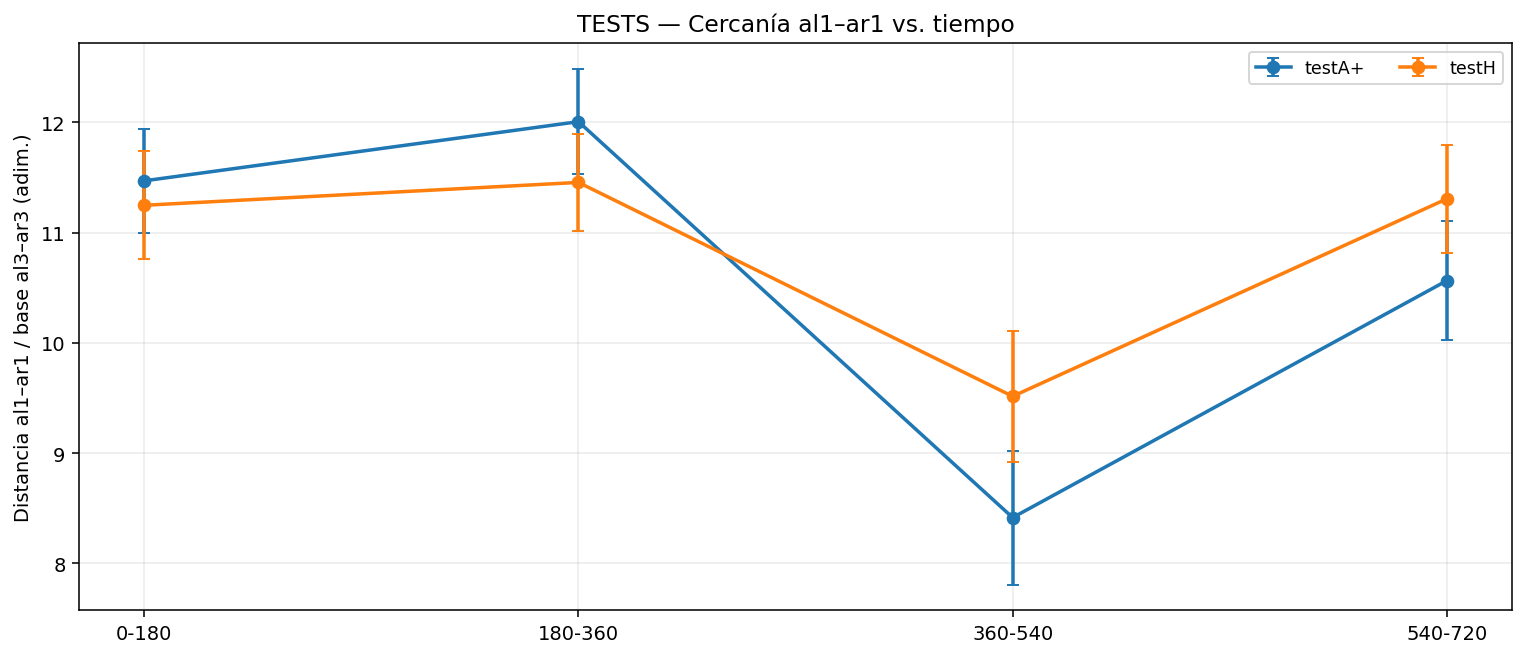


=== [TESTS] Wilcoxon pareado entre ventanas (Holm) por TEST ===
  test   win_a   win_b     W    p_raw   p_holm  n   sig stars
testA+   0-180 180-360  93.0 0.103404 0.103404 24 False    ns
testA+   0-180 360-540  16.0 0.000129 0.000644 24  True   ***
testA+   0-180 540-720  75.0 0.032125 0.064249 24 False    ns
testA+ 180-360 360-540  14.0 0.000102 0.000612 24  True   ***
testA+ 180-360 540-720  51.0 0.004676 0.014027 24  True     *
testA+ 360-540 540-720  22.0 0.000255 0.001020 24  True    **
 testH   0-180 180-360 138.0 0.509755 0.946369 25 False    ns
 testH   0-180 360-540  57.0 0.004530 0.018120 25  True     *
 testH   0-180 540-720 160.0 0.946369 0.946369 25 False    ns
 testH 180-360 360-540  39.0 0.000891 0.005343 25  True    **
 testH 180-360 540-720 139.0 0.527183 0.946369 25 False    ns
 testH 360-540 540-720  53.0 0.003216 0.016080 25  True     *


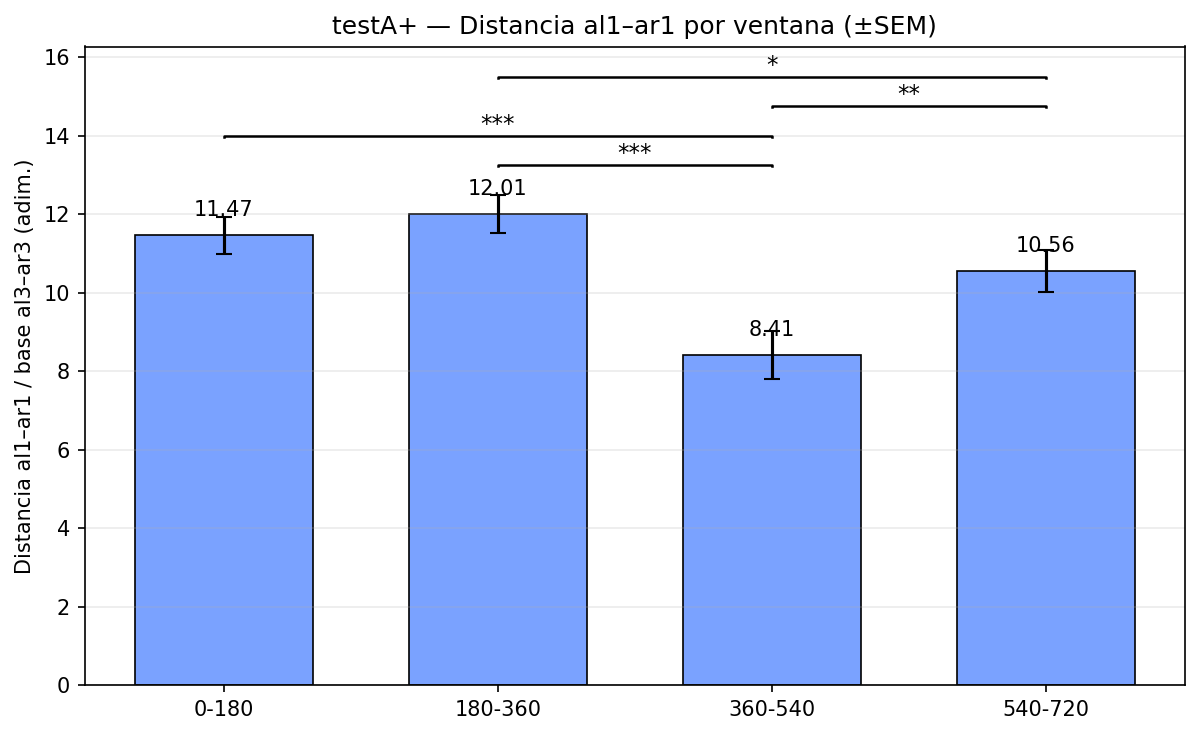

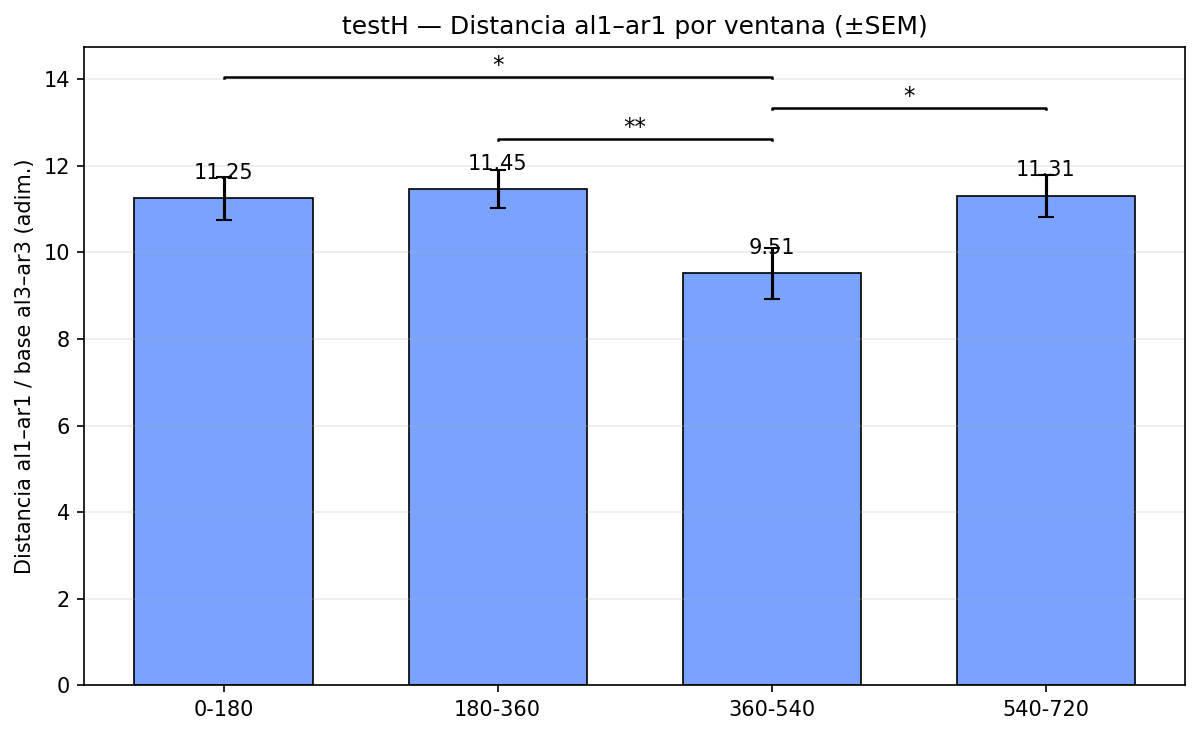


CSV exportado: al1_ar1_tests_significancia_wilcoxon_holm.csv


In [6]:
# -*- coding: utf-8 -*-
# Distancia al1–ar1 por ventana temporal (media por archivo → media ± SEM por trial/test).
# Visualización separada en TRIALS y TESTS, + barplots con significancia PARA TESTS.
#
# Estadística (solo TESTS):
#   - Dentro de cada TEST: Wilcoxon pareado entre ventanas (intersección de abejas), Holm.
#   - Se anotan en barplots por TEST con brackets y asteriscos.

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import wilcoxon

# =================== Configuración ===================
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# Ventanas temporales (frames) [a, b)
#WINDOWS = [(270, 360), (360, 450), (450, 540), (540, 630)]
WINDOWS = [(0, 180), (180, 360), (360, 540), (540, 720)]
WINDOW_LABELS = [f"{a}-{b}" for a, b in WINDOWS]

# Filtrado por likelihood
USE_LIKELIHOOD = True
LIK_THR = 0.6

# Normalizar la distancia al1–ar1 por la distancia al3–ar3
NORMALIZE_BY_BASE = True
MIN_BASE_PX = 5.0   # evita divisiones inestables si la base es muy chica

# Exportar CSVs
SAVE_CSV = True
CSV_PER_FILE   = "al1_ar1_closeness_por_archivo.csv"
CSV_BY_GROUP   = "al1_ar1_closeness_por_trialtest.csv"

# Parámetros estadísticos y de estilo de anotación
ALPHA = 0.05
MIN_SUBJECTS_PAIRED = 5  # mínimo de abejas en común por par de ventanas para test pareado
P_THRESH = [(0.001, "***"), (0.01, "**"), (0.05, "*")]  # mapeo p→asteriscos

# =================== Utilidades ===================
def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

def get_series(df: pd.DataFrame, bp: str, coord: str) -> np.ndarray:
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")
    cols = df.columns
    names = cols.names
    try:
        idx_bp = names.index("bodyparts"); idx_coord = names.index("coords")
    except ValueError:
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)
    for c in cols:
        if idx_bp is not None and idx_coord is not None and len(c) > max(idx_bp, idx_coord):
            if (c[idx_bp] == bp) and (c[idx_coord] == coord):
                return df.loc[:, c].astype(float).to_numpy()
    raise KeyError(f"No hallé columnas para {bp}-{coord}")

# trialX/testY al principio del nombre
NAME_RE = re.compile(r"^(?P<prefix>(?:trial|test)[^_]*)_", re.IGNORECASE)
def parse_group_and_animal(fname: str):
    stem = Path(fname).stem
    m = NAME_RE.match(stem)
    group = m.group("prefix") if m else stem
    # animal opcional
    an_m = re.search(r"(abeja\(\d+\))", fname, re.IGNORECASE)
    animal = an_m.group(1) if an_m else "abeja(?)"
    return group, animal

def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', str(s))]

def sem(x):
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    return np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else np.nan

def holm_correction(pvals):
    """Holm-Bonferroni para una lista de p-valores (array-like)."""
    p = np.array(pvals, dtype=float)
    m = len(p)
    order = np.argsort(p)  # asc
    adj = np.empty_like(p)
    for rank, idx in enumerate(order):
        adj[idx] = (m - rank) * p[idx]
    # Monotone non-decreasing
    adj_sorted = np.minimum.accumulate(adj[order][::-1])[::-1]
    out = np.empty_like(p)
    out[order] = np.clip(adj_sorted, 0, 1)
    return out

def p_to_stars(p):
    for thr, stars in P_THRESH:
        if p <= thr:
            return stars
    return "ns"

# =================== Loop: medir distancia al1–ar1 ===================
rows_file = []  # una fila por archivo y ventana

h5_files = sorted(FOLDER.glob("*.h5"), key=lambda p: natural_key(p.name))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        continue

    group, animal = parse_group_and_animal(h5.name)

    try:
        x_al1 = get_series(df, "al1", "x"); y_al1 = get_series(df, "al1", "y")
        x_ar1 = get_series(df, "ar1", "x"); y_ar1 = get_series(df, "ar1", "y")
        lk_al1 = get_series(df, "al1", "likelihood") if USE_LIKELIHOOD else None
        lk_ar1 = get_series(df, "ar1", "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[SKIP] {h5.name}: faltan al1/ar1 ({e})")
        continue

    # Base para normalización (opcional) — manejar por archivo sin tocar la global
    normalize_this = NORMALIZE_BY_BASE
    if normalize_this:
        try:
            x_al3 = get_series(df, "al3", "x"); y_al3 = get_series(df, "al3", "y")
            x_ar3 = get_series(df, "ar3", "x"); y_ar3 = get_series(df, "ar3", "y")
            lk_al3 = get_series(df, "al3", "likelihood") if USE_LIKELIHOOD else None
            lk_ar3 = get_series(df, "ar3", "likelihood") if USE_LIKELIHOOD else None
        except Exception as e:
            print(f"[WARN] {h5.name}: no puedo normalizar (faltan al3/ar3). Sigo con píxeles.")
            normalize_this = False

    n = min(len(x_al1), len(x_ar1))
    for (a, b), wlab in zip(WINDOWS, WINDOW_LABELS):
        aa = max(0, min(n, a)); bb = max(0, min(n, b))
        if bb - aa <= 0:
            continue

        # máscaras de validez en puntas
        valid_tips = np.isfinite(x_al1[aa:bb]) & np.isfinite(y_al1[aa:bb]) \
                   & np.isfinite(x_ar1[aa:bb]) & np.isfinite(y_ar1[aa:bb])
        if USE_LIKELIHOOD:
            if lk_al1 is not None: valid_tips &= (lk_al1[aa:bb] > LIK_THR)
            if lk_ar1 is not None: valid_tips &= (lk_ar1[aa:bb] > LIK_THR)
        if not np.any(valid_tips):
            continue

        # distancias crudas (px)
        dx = x_al1[aa:bb] - x_ar1[aa:bb]
        dy = y_al1[aa:bb] - y_ar1[aa:bb]
        dist_all = np.hypot(dx, dy)

        # normalización por base (si corresponde)
        if normalize_this:
            vb = np.isfinite(x_al3[aa:bb]) & np.isfinite(y_al3[aa:bb]) \
               & np.isfinite(x_ar3[aa:bb]) & np.isfinite(y_ar3[aa:bb])
            if USE_LIKELIHOOD and (lk_al3 is not None) and (lk_ar3 is not None):
                vb &= (lk_al3[aa:bb] > LIK_THR) & (lk_ar3[aa:bb] > LIK_THR)

            base_dx = x_al3[aa:bb] - x_ar3[aa:bb]
            base_dy = y_al3[aa:bb] - y_ar3[aa:bb]
            base_px = np.hypot(base_dx, base_dy)

            m = valid_tips & vb & np.isfinite(base_px) & (base_px >= MIN_BASE_PX)
            if not np.any(m):
                continue
            dist_px = dist_all[m]
            dist_norm = (dist_px / base_px[m])
            dist_px_used = dist_px  # para métricas en px también, si querés comparar
        else:
            m = valid_tips & np.isfinite(dist_all)
            if not np.any(m):
                continue
            dist_px_used = dist_all[m]
            dist_norm = np.array([])

        # Resumen por archivo & ventana
        rows_file.append({
            "file": h5.name,
            "trialtest": group,
            "animal": animal,
            "window": wlab,
            "n_frames_used": int(np.count_nonzero(m)),
            "dist_px_mean": float(np.nanmean(dist_px_used)) if dist_px_used.size else np.nan,
            "dist_px_median": float(np.nanmedian(dist_px_used)) if dist_px_used.size else np.nan,
            "dist_px_std": float(np.nanstd(dist_px_used, ddof=1)) if dist_px_used.size>1 else np.nan,
            "dist_norm_mean": float(np.nanmean(dist_norm)) if dist_norm.size else np.nan,
            "dist_norm_median": float(np.nanmedian(dist_norm)) if dist_norm.size else np.nan,
            "dist_norm_std": float(np.nanstd(dist_norm, ddof=1)) if dist_norm.size>1 else np.nan,
        })

df_file = pd.DataFrame(rows_file)
if df_file.empty:
    raise SystemExit("No hay datos válidos para calcular distancias al1–ar1.")

# =================== Agregado por trial/test y ventana ===================
def agg_sem(x): return sem(x)

df_group = (df_file
            .groupby(["trialtest","window"], as_index=False)
            .agg(dist_px_mean_mean=("dist_px_mean","mean"),
                 dist_px_mean_sem =("dist_px_mean", agg_sem),
                 dist_px_n=("dist_px_mean","count"),
                 dist_norm_mean_mean=("dist_norm_mean","mean"),
                 dist_norm_mean_sem =("dist_norm_mean", agg_sem),
                 dist_norm_n=("dist_norm_mean","count")))

# Orden natural
df_group["trialtest"] = pd.Categorical(df_group["trialtest"],
                                       categories=sorted(df_group["trialtest"].unique(), key=natural_key),
                                       ordered=True)
df_group["window"] = pd.Categorical(df_group["window"],
                                    categories=WINDOW_LABELS, ordered=True)
df_group = df_group.sort_values(["trialtest","window"])

print("\n=== Distancia al1–ar1 por archivo (mean por ventana) ===")
print(df_file.head().to_string(index=False))
print(f"\nFilas: {len(df_file)}   Archivos únicos: {df_file['file'].nunique()}")

print("\n=== Agregado por trial/test y ventana (media de medias ± SEM) ===")
print(df_group.to_string(index=False))

# =================== CSVs ===================
if SAVE_CSV:
    df_file.to_csv(CSV_PER_FILE, index=False)
    df_group.to_csv(CSV_BY_GROUP, index=False)
    print(f"\nCSV exportados: {CSV_PER_FILE}, {CSV_BY_GROUP}")

# =================== Visualizaciones — separadas TRIALS / TESTS ===================
# Métrica a graficar en heatmaps/curvas
use_norm = df_group["dist_norm_mean_mean"].notna().any()
val_col = "dist_norm_mean_mean" if use_norm else "dist_px_mean_mean"
sem_col = "dist_norm_mean_sem"  if use_norm else "dist_px_mean_sem"
zlabel  = "Distancia al1–ar1 / base al3–ar3 (adim.)" if use_norm else "Distancia al1–ar1 (px)"

def plot_category(sub_all: pd.DataFrame, prefix: str, title_tag: str):
    mask = sub_all["trialtest"].astype(str).str.lower().str.startswith(prefix)
    sub = sub_all[mask]
    if sub.empty:
        return
    ordered_groups = [g for g in df_group["trialtest"].cat.categories if str(g).lower().startswith(prefix)]

    # Heatmap
    pv = sub.pivot(index="trialtest", columns="window", values=val_col).reindex(ordered_groups)
    fig_h = 0.6*max(1, len(pv.index)) + 3
    fig, ax = plt.subplots(figsize=(1.8*len(WINDOW_LABELS)+3, fig_h), dpi=140)
    im = ax.imshow(pv.values, aspect="auto")
    ax.set_xticks(np.arange(len(WINDOW_LABELS)), WINDOW_LABELS)
    ax.set_yticks(np.arange(len(pv.index)), pv.index)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(zlabel)
    ax.set_title(f"{title_tag} — Cercanía al1–ar1 por ventana")
    for i in range(pv.shape[0]):
        for j in range(pv.shape[1]):
            v = pv.values[i, j]
            if np.isfinite(v):
                ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color="white")
    plt.tight_layout()
    plt.show()

    # Curvas
    groups = [g for g in ordered_groups if g in sub["trialtest"].unique()]
    fig_w = 2.0*len(WINDOW_LABELS)+3
    fig, ax = plt.subplots(figsize=(fig_w, 4.8), dpi=140)
    for g in groups:
        sub_g = sub[sub["trialtest"] == g].sort_values("window")
        ax.errorbar(np.arange(len(WINDOW_LABELS)),
                    sub_g[val_col].to_numpy(float),
                    yerr=sub_g[sem_col].to_numpy(float),
                    marker="o", linewidth=1.8, capsize=3, label=g)
    ax.set_xticks(np.arange(len(WINDOW_LABELS)), WINDOW_LABELS)
    ax.set_ylabel(zlabel)
    ax.set_title(f"{title_tag} — Cercanía al1–ar1 vs. tiempo")
    ax.grid(True, alpha=0.25)
    ax.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

# TRIALS
plot_category(df_group, prefix="trial", title_tag="TRIALS")
# TESTS
plot_category(df_group, prefix="test",  title_tag="TESTS")

# =================== ESTADÍSTICA Y BARRAS (SOLO TESTS) ===================
# Para anotar significancia entre ventanas dentro de cada TEST
# 1) Elegimos métrica de trabajo a nivel FILA (preferir normalizada)
df_tests = df_file[df_file["trialtest"].str.lower().str.startswith("test")].copy()
if df_tests.empty:
    print("\n[ESTADÍSTICA TESTS] No hay filas de tests.")
else:
    df_tests["metric"] = np.where(df_tests["dist_norm_mean"].notna(),
                                  df_tests["dist_norm_mean"], df_tests["dist_px_mean"]).astype(float)

    def compute_paired_stats_for_test(test_name: str):
        """Wilcoxon pareado entre ventanas para un test (intersección de abejas por par de ventanas)."""
        sub = df_tests[df_tests["trialtest"] == test_name].copy()
        if sub.empty:
            return []

        # Pivot animal x ventana (media por archivo-ventana ya está; aquí un valor por combinación)
        pv = sub[["animal", "window", "metric"]].dropna().pivot_table(
            index="animal", columns="window", values="metric", aggfunc="mean"
        ).reindex(columns=WINDOW_LABELS)

        pairs = []
        raw_ps = []
        idx_pairs = []
        # Recorremos pares de ventanas que existan en columnas
        valid_cols = [c for c in WINDOW_LABELS if c in pv.columns]
        for a, b in combinations(valid_cols, 2):
            both = pv[[a, b]].dropna()
            if len(both) >= MIN_SUBJECTS_PAIRED:
                xa = both[a].to_numpy(float)
                xb = both[b].to_numpy(float)
                if np.allclose(xa, xb, equal_nan=False):
                    W, p = 0.0, 1.0
                else:
                    W, p = wilcoxon(xa, xb, zero_method="wilcox", mode="approx")
                pairs.append((a, b, W, p, len(both)))
                raw_ps.append(p)
                idx_pairs.append((a, b))

        if not pairs:
            return []

        # Holm por test
        p_adj = holm_correction(raw_ps)
        out = []
        for (a, b), (A, B, W, p_raw, n), p_corr in zip(idx_pairs, pairs, p_adj):
            out.append({
                "test": test_name, "win_a": a, "win_b": b,
                "W": float(W), "p_raw": float(p_raw), "p_holm": float(p_corr),
                "n": int(n), "sig": p_corr < ALPHA, "stars": p_to_stars(p_corr)
            })
        return out

    # Estadística por test
    all_stats = []
    test_names = sorted(df_tests["trialtest"].unique(), key=natural_key)
    for tname in test_names:
        all_stats.extend(compute_paired_stats_for_test(tname))
    df_sig = pd.DataFrame(all_stats)

    if not df_sig.empty:
        print("\n=== [TESTS] Wilcoxon pareado entre ventanas (Holm) por TEST ===")
        print(df_sig.to_string(index=False))
    else:
        print("\n[TESTS] Sin pares con n suficiente para Wilcoxon.")

    # ====== BARPLOTS por TEST con significancia ======
    # Tomamos medias y SEM desde df_group (agregado por trialtest x window)
    df_tests_group = df_group[df_group["trialtest"].astype(str).str.lower().str.startswith("test")].copy()

    def annotate_bracket(ax, x1, x2, y, text, h=0.02, lw=1.2, fs=11):
        """Dibuja bracket de significancia entre barras x1 y x2 a altura y."""
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
        ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=fs)

    for tname in test_names:
        sub = df_tests_group[df_tests_group["trialtest"] == tname].sort_values("window")
        if sub.empty:
            continue

        means = sub[val_col].to_numpy(float)
        errs  = sub[sem_col].to_numpy(float)
        labels = sub["window"].tolist()

        # Posiciones de barras solo para ventanas presentes
        xs = np.arange(len(labels))

        fig_w = max(6.0, 1.4*len(labels) + 2.5)
        fig, ax = plt.subplots(figsize=(fig_w, 5.0), dpi=150)

        bars = ax.bar(xs, means, yerr=errs, capsize=4, width=0.65, color="#7aa2ff", edgecolor="black", linewidth=0.8)
        ax.set_xticks(xs, labels)
        ax.set_ylabel(zlabel)
        ax.set_title(f"{tname} — Distancia al1–ar1 por ventana (±SEM)")

        # Texto encima de cada barra
        ymax = np.nanmax(means + np.nan_to_num(errs, nan=0.0))
        for x, m, e in zip(xs, means, errs):
            if np.isfinite(m):
                ax.text(x, m + (ymax*0.03 if np.isfinite(ymax) and ymax>0 else 0.03), f"{m:.2f}",
                        ha="center", va="bottom", fontsize=10)

        # Añadir brackets de significancia usando df_sig
        sub_sig = df_sig[df_sig["test"] == tname] if not df_sig.empty else pd.DataFrame()
        # Solo pares que involucran etiquetas presentes en este subplot
        if not sub_sig.empty:
            sub_sig = sub_sig[sub_sig["win_a"].isin(labels) & sub_sig["win_b"].isin(labels)]
            # Ordenamos por p para colocar de abajo hacia arriba
            sub_sig = sub_sig.sort_values("p_holm")

            # Mapa ventana→x
            idx_map = {lab: i for i, lab in enumerate(labels)}
            # Altura base para brackets
            base = ymax + (0.06*ymax if np.isfinite(ymax) and ymax>0 else 0.06)
            step = 0.06 * (ymax if np.isfinite(ymax) and ymax>0 else 1.0)
            level = 0
            used_pairs = []

            for _, row in sub_sig.iterrows():
                if not row.get("sig", False):
                    continue
                a, b = row["win_a"], row["win_b"]
                x1, x2 = idx_map[a], idx_map[b]
                if x1 == x2:
                    continue
                lo, hi = min(x1, x2), max(x1, x2)
                # Colocar escalonado evitando solapamientos simples
                y = base + level*step
                annotate_bracket(ax, lo, hi, y, row["stars"])
                used_pairs.append((lo, hi))
                level += 1

        ax.grid(axis="y", alpha=0.25)
        plt.tight_layout()
        plt.show()

    # (Opcional) exportar CSV de significancias
    if SAVE_CSV and not df_sig.empty:
        df_sig.to_csv("al1_ar1_tests_significancia_wilcoxon_holm.csv", index=False)
        print("\nCSV exportado: al1_ar1_tests_significancia_wilcoxon_holm.csv")



=== Distancia al1–ar1 por archivo (mean por ventana) ===
              file trialtest   animal  window  n_frames_used  dist_px_mean  dist_px_median  dist_px_std  dist_norm_mean  dist_norm_median  dist_norm_std  band_80–130 px_frames  band_80–130 px_seconds  band_130–180 px_frames  band_130–180 px_seconds
testA+_abeja(1).h5    testA+ abeja(1)   0-180            103    188.255664      184.953123    27.618563       13.850777         14.001524       2.305461                      2                0.033333                      39                 0.650000
testA+_abeja(1).h5    testA+ abeja(1) 180-360            157    194.398736      194.182103    33.611661       14.130606         14.452467       2.779988                      6                0.100000                      45                 0.750000
testA+_abeja(1).h5    testA+ abeja(1) 360-540            150    115.591440      113.121545    28.612512        7.857982          7.756600       2.175539                     87                1.45

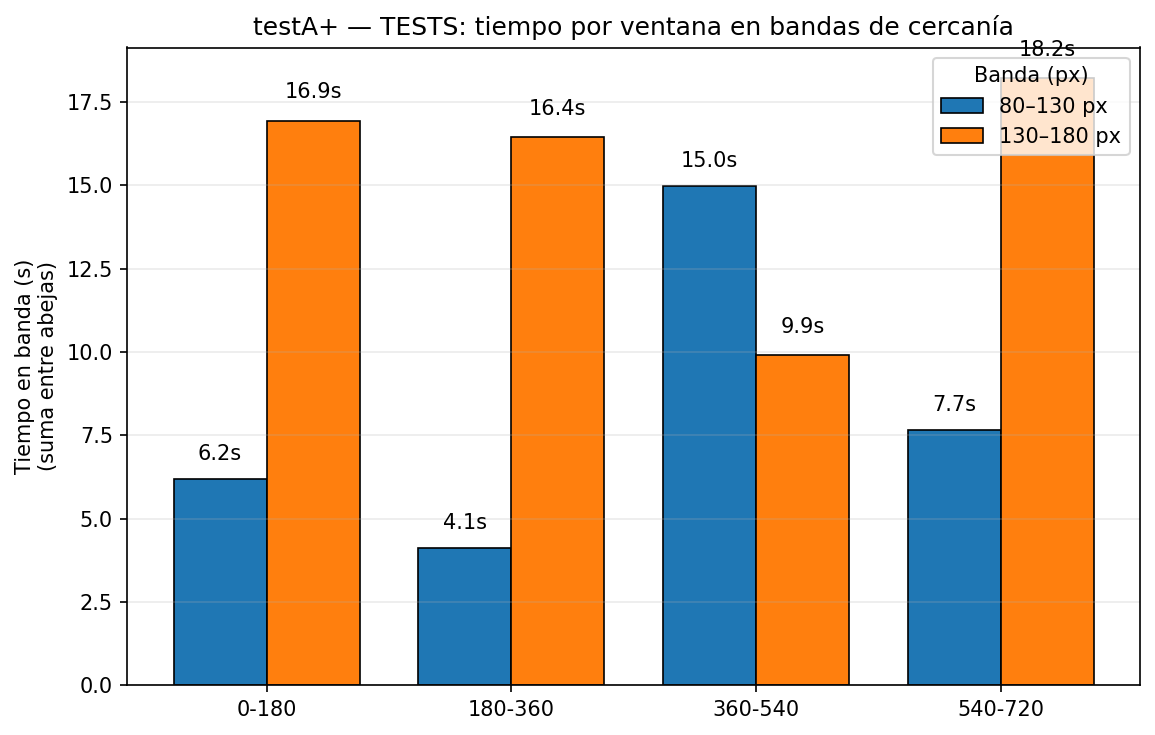

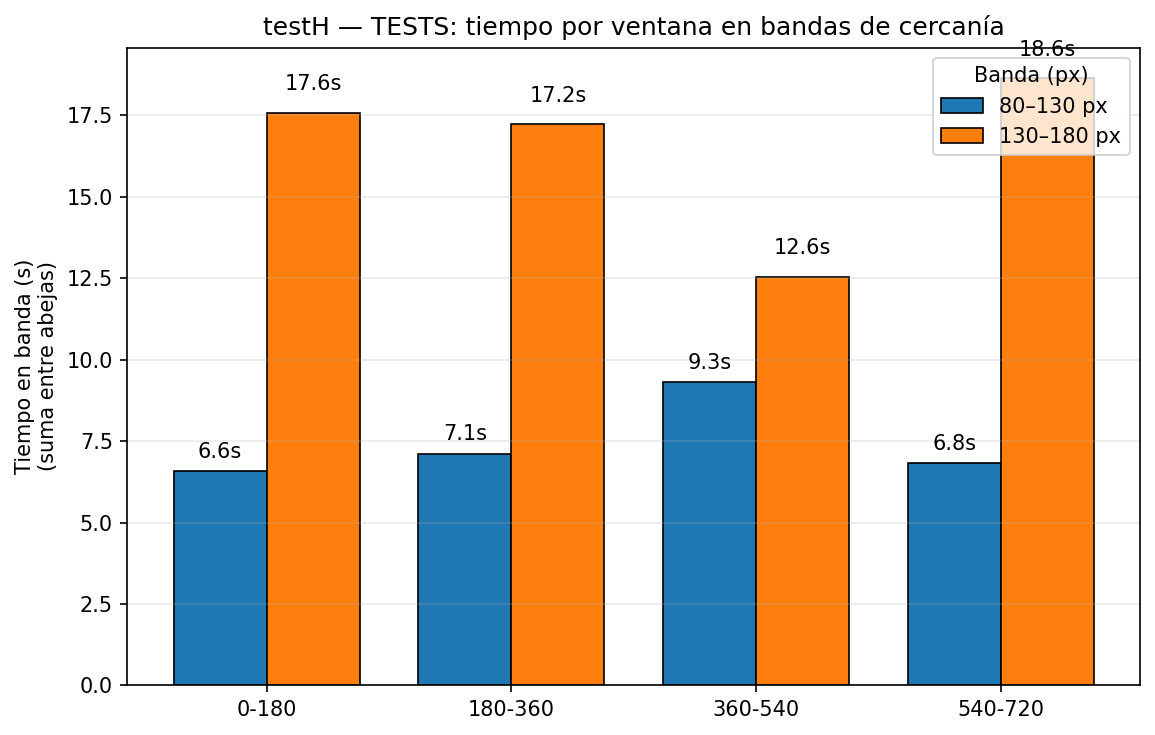

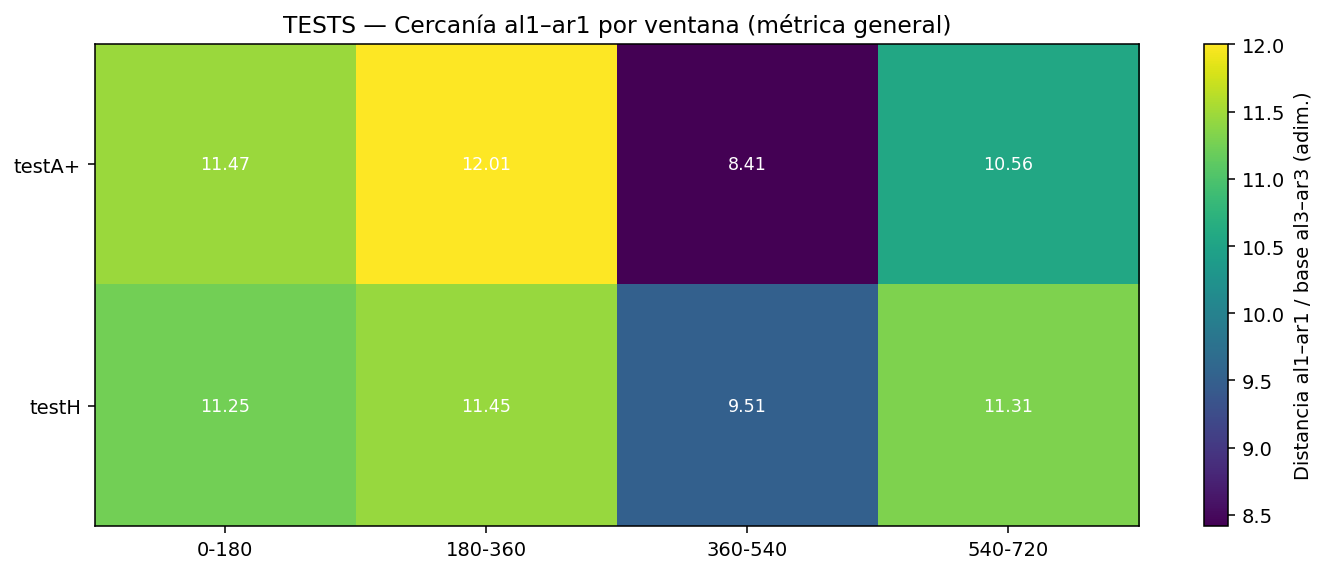

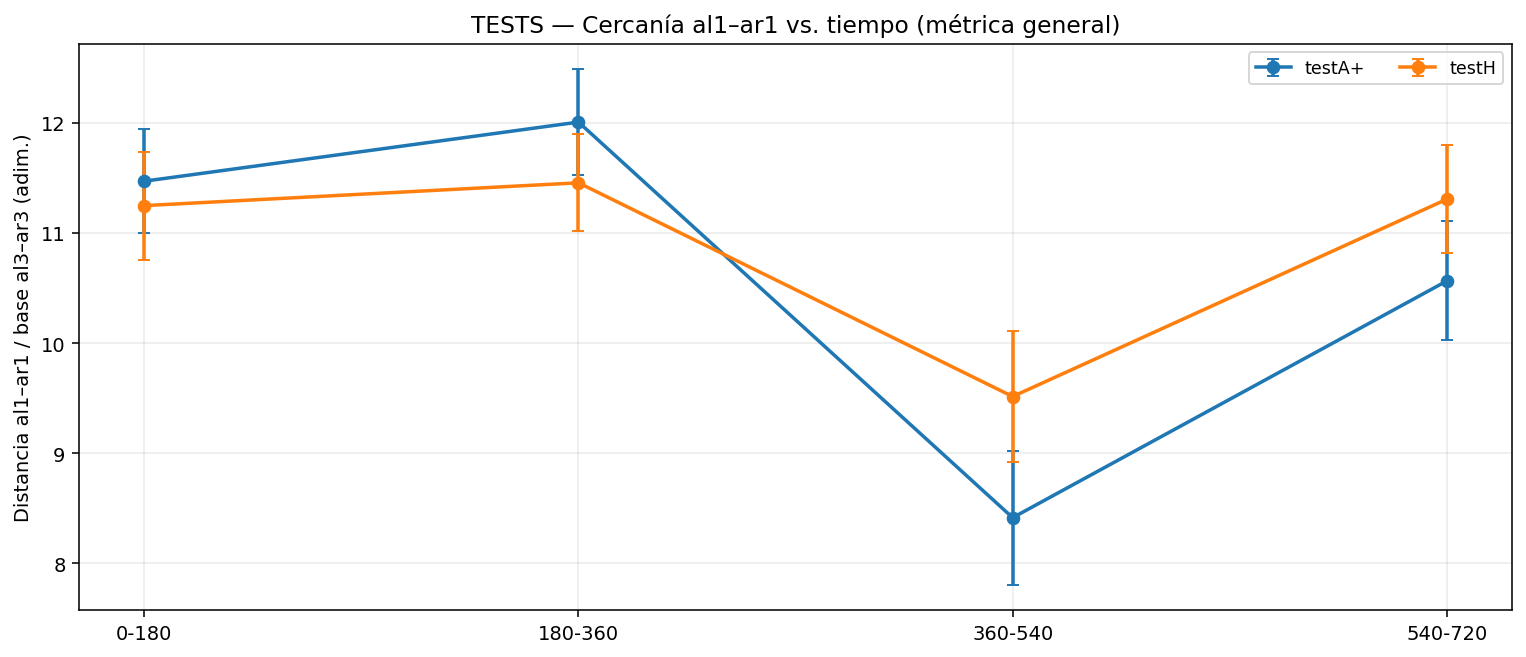

In [7]:
# -*- coding: utf-8 -*-
# Distancia al1–ar1 por ventana temporal (media por archivo → media ± SEM por trial/test).
# Visualización separada en TRIALS y TESTS, + barplots con significancia PARA TESTS.
#
# *** NUEVO ***: Tiempo (en segundos) dentro de bandas de cercanía en píxeles (80–130 y 130–180)
# por ventana temporal y por trial/test, agregando por suma entre abejas. Barplots separados.

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import wilcoxon

# =================== Configuración ===================
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# Ventanas temporales (frames) [a, b)
WINDOWS = [(0, 180), (180, 360), (360, 540), (540, 720)]
WINDOW_LABELS = [f"{a}-{b}" for a, b in WINDOWS]

# FPS para convertir frames -> segundos (usado para bandas)
FPS = 60

# Filtrado por likelihood
USE_LIKELIHOOD = True
LIK_THR = 0.6

# Normalizar la distancia al1–ar1 por la distancia al3–ar3 (para métricas generales; NO para bandas)
NORMALIZE_BY_BASE = True
MIN_BASE_PX = 5.0

# Exportar CSVs
SAVE_CSV = True
CSV_PER_FILE   = "al1_ar1_closeness_por_archivo.csv"
CSV_BY_GROUP   = "al1_ar1_closeness_por_trialtest.csv"
CSV_BANDS_FILE = "al1_ar1_bandas_tiempo_por_trialtest_window.csv"

# Estadística (solo TESTS; se mantiene de tu script)
ALPHA = 0.05
MIN_SUBJECTS_PAIRED = 5
P_THRESH = [(0.001, "***"), (0.01, "**"), (0.05, "*")]

# *** NUEVO *** Bandas en píxeles (incluyentes)
BANDS_PX = [(80, 130), (130, 180)]
BAND_LABELS = [f"{a}–{b} px" for a, b in BANDS_PX]

# =================== Utilidades ===================
def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

def get_series(df: pd.DataFrame, bp: str, coord: str) -> np.ndarray:
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")
    cols = df.columns
    names = cols.names
    try:
        idx_bp = names.index("bodyparts"); idx_coord = names.index("coords")
    except ValueError:
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)
    for c in cols:
        if idx_bp is not None and idx_coord is not None and len(c) > max(idx_bp, idx_coord):
            if (c[idx_bp] == bp) and (c[idx_coord] == coord):
                return df.loc[:, c].astype(float).to_numpy()
    raise KeyError(f"No hallé columnas para {bp}-{coord}")

NAME_RE = re.compile(r"^(?P<prefix>(?:trial|test)[^_]*)_", re.IGNORECASE)
def parse_group_and_animal(fname: str):
    stem = Path(fname).stem
    m = NAME_RE.match(stem)
    group = m.group("prefix") if m else stem
    an_m = re.search(r"(abeja\(\d+\))", fname, re.IGNORECASE)
    animal = an_m.group(1) if an_m else "abeja(?)"
    return group, animal

def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', str(s))]

def sem(x):
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    return np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else np.nan

def holm_correction(pvals):
    p = np.array(pvals, dtype=float)
    m = len(p)
    order = np.argsort(p)
    adj = np.empty_like(p)
    for rank, idx in enumerate(order):
        adj[idx] = (m - rank) * p[idx]
    adj_sorted = np.minimum.accumulate(adj[order][::-1])[::-1]
    out = np.empty_like(p)
    out[order] = np.clip(adj_sorted, 0, 1)
    return out

def p_to_stars(p):
    for thr, stars in P_THRESH:
        if p <= thr:
            return stars
    return "ns"

def annotate_bracket(ax, x1, x2, y, text, h=0.02, lw=1.2, fs=11):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=fs)

# =================== Loop: medir distancia al1–ar1 ===================
rows_file = []  # una fila por archivo y ventana

h5_files = sorted(FOLDER.glob("*.h5"), key=lambda p: natural_key(p.name))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        continue

    group, animal = parse_group_and_animal(h5.name)

    try:
        x_al1 = get_series(df, "al1", "x"); y_al1 = get_series(df, "al1", "y")
        x_ar1 = get_series(df, "ar1", "x"); y_ar1 = get_series(df, "ar1", "y")
        lk_al1 = get_series(df, "al1", "likelihood") if USE_LIKELIHOOD else None
        lk_ar1 = get_series(df, "ar1", "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[SKIP] {h5.name}: faltan al1/ar1 ({e})")
        continue

    # Base (para métrica normalizada; NO requerida para bandas en px)
    normalize_this = NORMALIZE_BY_BASE
    if normalize_this:
        try:
            x_al3 = get_series(df, "al3", "x"); y_al3 = get_series(df, "al3", "y")
            x_ar3 = get_series(df, "ar3", "x"); y_ar3 = get_series(df, "ar3", "y")
            lk_al3 = get_series(df, "al3", "likelihood") if USE_LIKELIHOOD else None
            lk_ar3 = get_series(df, "ar3", "likelihood") if USE_LIKELIHOOD else None
        except Exception as e:
            print(f"[WARN] {h5.name}: no puedo normalizar (faltan al3/ar3). Sigo con píxeles.")
            normalize_this = False

    n = min(len(x_al1), len(x_ar1))
    for (a, b), wlab in zip(WINDOWS, WINDOW_LABELS):
        aa = max(0, min(n, a)); bb = max(0, min(n, b))
        if bb - aa <= 0:
            continue

        # Validez por likelihood y finitud en puntas
        valid_tips = np.isfinite(x_al1[aa:bb]) & np.isfinite(y_al1[aa:bb]) \
                   & np.isfinite(x_ar1[aa:bb]) & np.isfinite(y_ar1[aa:bb])
        if USE_LIKELIHOOD:
            if lk_al1 is not None: valid_tips &= (lk_al1[aa:bb] > LIK_THR)
            if lk_ar1 is not None: valid_tips &= (lk_ar1[aa:bb] > LIK_THR)
        if not np.any(valid_tips):
            continue

        # Distancia cruda al1–ar1 (px) para bandas (en píxeles)
        dx = x_al1[aa:bb] - x_ar1[aa:bb]
        dy = y_al1[aa:bb] - y_ar1[aa:bb]
        dist_all = np.hypot(dx, dy)
        m_px = valid_tips & np.isfinite(dist_all)

        # ----- *** NUEVO ***: conteo por bandas en píxeles (incluye extremos) -----
        band_frames = []
        band_secs   = []
        for (lo, hi) in BANDS_PX:
            in_band = m_px & (dist_all >= lo) & (dist_all <= hi)
            n_fr = int(np.count_nonzero(in_band))
            band_frames.append(n_fr)
            band_secs.append(n_fr / float(FPS))

        # ----- Métricas generales como antes (px y, si corresponde, normalizado) -----
        if normalize_this:
            vb = np.isfinite(x_al3[aa:bb]) & np.isfinite(y_al3[aa:bb]) \
               & np.isfinite(x_ar3[aa:bb]) & np.isfinite(y_ar3[aa:bb])
            if USE_LIKELIHOOD and (lk_al3 is not None) and (lk_ar3 is not None):
                vb &= (lk_al3[aa:bb] > LIK_THR) & (lk_ar3[aa:bb] > LIK_THR)

            base_dx = x_al3[aa:bb] - x_ar3[aa:bb]
            base_dy = y_al3[aa:bb] - y_ar3[aa:bb]
            base_px = np.hypot(base_dx, base_dy)

            m = valid_tips & vb & np.isfinite(base_px) & (base_px >= MIN_BASE_PX)
            if not np.any(m):
                continue
            dist_px = dist_all[m]
            dist_norm = (dist_px / base_px[m])
            dist_px_used = dist_px
        else:
            m = m_px
            if not np.any(m):
                continue
            dist_px_used = dist_all[m]
            dist_norm = np.array([])

        row = {
            "file": h5.name,
            "trialtest": group,
            "animal": animal,
            "window": wlab,
            "n_frames_used": int(np.count_nonzero(m)),
            "dist_px_mean": float(np.nanmean(dist_px_used)) if dist_px_used.size else np.nan,
            "dist_px_median": float(np.nanmedian(dist_px_used)) if dist_px_used.size else np.nan,
            "dist_px_std": float(np.nanstd(dist_px_used, ddof=1)) if dist_px_used.size>1 else np.nan,
            "dist_norm_mean": float(np.nanmean(dist_norm)) if dist_norm.size else np.nan,
            "dist_norm_median": float(np.nanmedian(dist_norm)) if dist_norm.size else np.nan,
            "dist_norm_std": float(np.nanstd(dist_norm, ddof=1)) if dist_norm.size>1 else np.nan,
        }
        # Agrega columnas de bandas
        for bi, lab in enumerate(BAND_LABELS):
            row[f"band_{lab}_frames"]  = band_frames[bi]
            row[f"band_{lab}_seconds"] = band_secs[bi]

        rows_file.append(row)

df_file = pd.DataFrame(rows_file)
if df_file.empty:
    raise SystemExit("No hay datos válidos para calcular distancias al1–ar1.")

# =================== Agregado por trial/test y ventana (métricas generales) ===================
def agg_sem(x): return sem(x)

df_group = (df_file
            .groupby(["trialtest","window"], as_index=False)
            .agg(dist_px_mean_mean=("dist_px_mean","mean"),
                 dist_px_mean_sem =("dist_px_mean", agg_sem),
                 dist_px_n=("dist_px_mean","count"),
                 dist_norm_mean_mean=("dist_norm_mean","mean"),
                 dist_norm_mean_sem =("dist_norm_mean", agg_sem),
                 dist_norm_n=("dist_norm_mean","count")))

# Orden natural
df_group["trialtest"] = pd.Categorical(df_group["trialtest"],
                                       categories=sorted(df_group["trialtest"].unique(), key=natural_key),
                                       ordered=True)
df_group["window"] = pd.Categorical(df_group["window"],
                                    categories=WINDOW_LABELS, ordered=True)
df_group = df_group.sort_values(["trialtest","window"])

print("\n=== Distancia al1–ar1 por archivo (mean por ventana) ===")
print(df_file.head().to_string(index=False))
print(f"\nFilas: {len(df_file)}   Archivos únicos: {df_file['file'].nunique()}")

print("\n=== Agregado por trial/test y ventana (media de medias ± SEM) ===")
print(df_group.to_string(index=False))

# =================== *** NUEVO *** Agregado de TIEMPO en bandas ===================
band_frame_cols  = [f"band_{lab}_frames"  for lab in BAND_LABELS]
band_second_cols = [f"band_{lab}_seconds" for lab in BAND_LABELS]

# Suma entre abejas por trialtest × window
agg_map = {col: "sum" for col in (band_frame_cols + band_second_cols)}
df_bands_sum = (df_file
                .groupby(["trialtest","window"], as_index=False)
                .agg(**{c:(c,"sum") for c in agg_map.keys()}))
# Reordenar categorías
df_bands_sum["trialtest"] = pd.Categorical(df_bands_sum["trialtest"],
                                           categories=list(df_group["trialtest"].cat.categories),
                                           ordered=True)
df_bands_sum["window"] = pd.Categorical(df_bands_sum["window"],
                                        categories=WINDOW_LABELS, ordered=True)
df_bands_sum = df_bands_sum.sort_values(["trialtest","window"])

# Versión larga (long) para graficar fácil (usamos segundos)
rows_long = []
for _, r in df_bands_sum.iterrows():
    for lab in BAND_LABELS:
        secs = r[f"band_{lab}_seconds"]
        frms = r[f"band_{lab}_frames"]
        rows_long.append({
            "trialtest": r["trialtest"],
            "window": r["window"],
            "band": lab,
            "seconds_sum": float(secs),
            "frames_sum": int(frms)
        })
df_bands_long = pd.DataFrame(rows_long)

print("\n=== TIEMPO en bandas (suma entre abejas) por trial/test × ventana ===")
print(df_bands_long.head().to_string(index=False))

if SAVE_CSV:
    df_bands_long.to_csv(CSV_BANDS_FILE, index=False)
    print(f"\nCSV exportado de bandas: {CSV_BANDS_FILE}")

# =================== Visualizaciones — separadas TRIALS / TESTS (bandas) ===================
def plot_bands_category(df_long: pd.DataFrame, prefix: str, title_tag: str):
    mask = df_long["trialtest"].astype(str).str.lower().str.startswith(prefix)
    sub = df_long[mask]
    if sub.empty:
        return
    ordered_groups = [g for g in df_group["trialtest"].cat.categories if str(g).lower().startswith(prefix)]
    # Recorremos cada trial/test y graficamos barras agrupadas por ventana (dos barras = bandas)
    for g in ordered_groups:
        gdat = sub[sub["trialtest"] == g]
        if gdat.empty:
            continue
        # Pivot: filas=window, cols=band -> seconds_sum
        pv = (gdat
              .pivot_table(index="window", columns="band", values="seconds_sum", aggfunc="sum")
              .reindex(index=WINDOW_LABELS, columns=BAND_LABELS))
        if pv.isna().all().all():
            continue

        x = np.arange(len(pv.index))
        width = 0.38
        fig_w = max(6.5, 1.2*len(pv.index) + 3)
        fig, ax = plt.subplots(figsize=(fig_w, 5.0), dpi=150)

        offset = -width/2
        for bi, band in enumerate(BAND_LABELS):
            vals = pv[band].to_numpy(float)
            ax.bar(x + offset + bi*width, vals, width, label=band, edgecolor="black", linewidth=0.8)

            # Etiquetas numéricas arriba
            ymax = np.nanmax(vals) if np.isfinite(np.nanmax(vals)) else 0.0
            bump = (0.03*ymax if ymax > 0 else 0.03)
            for xi, v in enumerate(vals):
                if np.isfinite(v):
                    ax.text(xi + offset + bi*width, v + bump, f"{v:.1f}s",
                            ha="center", va="bottom", fontsize=10)

        ax.set_xticks(x, pv.index.tolist())
        ax.set_ylabel("Tiempo en banda (s)\n(suma entre abejas)")
        ax.set_title(f"{g} — {title_tag}: tiempo por ventana en bandas de cercanía")
        ax.grid(axis="y", alpha=0.25)
        ax.legend(title="Banda (px)")
        plt.tight_layout()
        plt.show()

# TRIALS
plot_bands_category(df_bands_long, prefix="trial", title_tag="TRIALS")
# TESTS
plot_bands_category(df_bands_long, prefix="test",  title_tag="TESTS")

# =================== (Se mantiene) Visualizaciones generales y estadística de tu script ===================
# Métrica para heatmaps/curvas generales
use_norm = df_group["dist_norm_mean_mean"].notna().any()
val_col = "dist_norm_mean_mean" if use_norm else "dist_px_mean_mean"
sem_col = "dist_norm_mean_sem"  if use_norm else "dist_px_mean_sem"
zlabel  = "Distancia al1–ar1 / base al3–ar3 (adim.)" if use_norm else "Distancia al1–ar1 (px)"

def plot_category_general(sub_all: pd.DataFrame, prefix: str, title_tag: str):
    mask = sub_all["trialtest"].astype(str).str.lower().str.startswith(prefix)
    sub = sub_all[mask]
    if sub.empty:
        return
    ordered_groups = [g for g in df_group["trialtest"].cat.categories if str(g).lower().startswith(prefix)]

    pv = sub.pivot(index="trialtest", columns="window", values=val_col).reindex(ordered_groups)
    fig_h = 0.6*max(1, len(pv.index)) + 3
    fig, ax = plt.subplots(figsize=(1.8*len(WINDOW_LABELS)+3, fig_h), dpi=140)
    im = ax.imshow(pv.values, aspect="auto")
    ax.set_xticks(np.arange(len(WINDOW_LABELS)), WINDOW_LABELS)
    ax.set_yticks(np.arange(len(pv.index)), pv.index)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(zlabel)
    ax.set_title(f"{title_tag} — Cercanía al1–ar1 por ventana (métrica general)")
    for i in range(pv.shape[0]):
        for j in range(pv.shape[1]):
            v = pv.values[i, j]
            if np.isfinite(v):
                ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color="white")
    plt.tight_layout()
    plt.show()

    groups = [g for g in ordered_groups if g in sub["trialtest"].unique()]
    fig_w = 2.0*len(WINDOW_LABELS)+3
    fig, ax = plt.subplots(figsize=(fig_w, 4.8), dpi=140)
    for g in groups:
        sub_g = sub[sub["trialtest"] == g].sort_values("window")
        ax.errorbar(np.arange(len(WINDOW_LABELS)),
                    sub_g[val_col].to_numpy(float),
                    yerr=sub_g[sem_col].to_numpy(float),
                    marker="o", linewidth=1.8, capsize=3, label=g)
    ax.set_xticks(np.arange(len(WINDOW_LABELS)), WINDOW_LABELS)
    ax.set_ylabel(zlabel)
    ax.set_title(f"{title_tag} — Cercanía al1–ar1 vs. tiempo (métrica general)")
    ax.grid(True, alpha=0.25)
    ax.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

plot_category_general(df_group, prefix="trial", title_tag="TRIALS")
plot_category_general(df_group, prefix="test",  title_tag="TESTS")

# ======= (Opcional) Estadística Wilcoxon + brackets por TEST (como tenías) =======
# ... (puedes dejar aquí tu bloque original de estadística si querés mantenerlo)



=== Tiempo en bandas por archivo (segundos) — primeras filas ===
              file trialtest   animal  window  n_frames_valid  B80_130_frames  B130_180_frames  B80_130_seconds  B130_180_seconds
testA+_abeja(1).h5    testA+ abeja(1)   0-180             103               2               39         0.033333          0.650000
testA+_abeja(1).h5    testA+ abeja(1) 180-360             157               6               45         0.100000          0.750000
testA+_abeja(1).h5    testA+ abeja(1) 360-540             150              87               44         1.450000          0.733333
testA+_abeja(1).h5    testA+ abeja(1) 540-720             123              31               56         0.516667          0.933333
testA+_abeja(2).h5    testA+ abeja(2)   0-180             108              17               33         0.283333          0.550000

Filas (archivo×ventana): 196   Archivos únicos: 49

=== PROMEDIO por abeja (mean ± SEM) de tiempo en bandas por trial/test × ventana ===
trialtest  windo

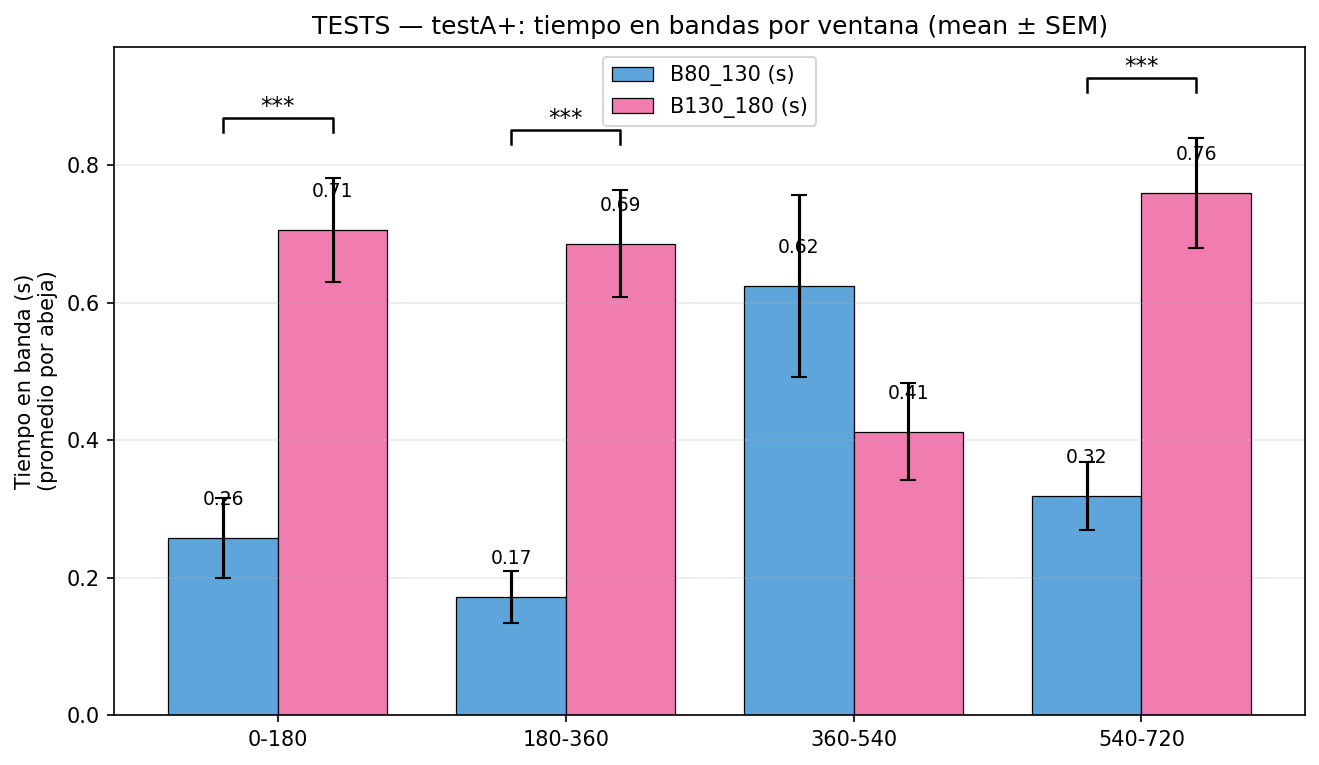

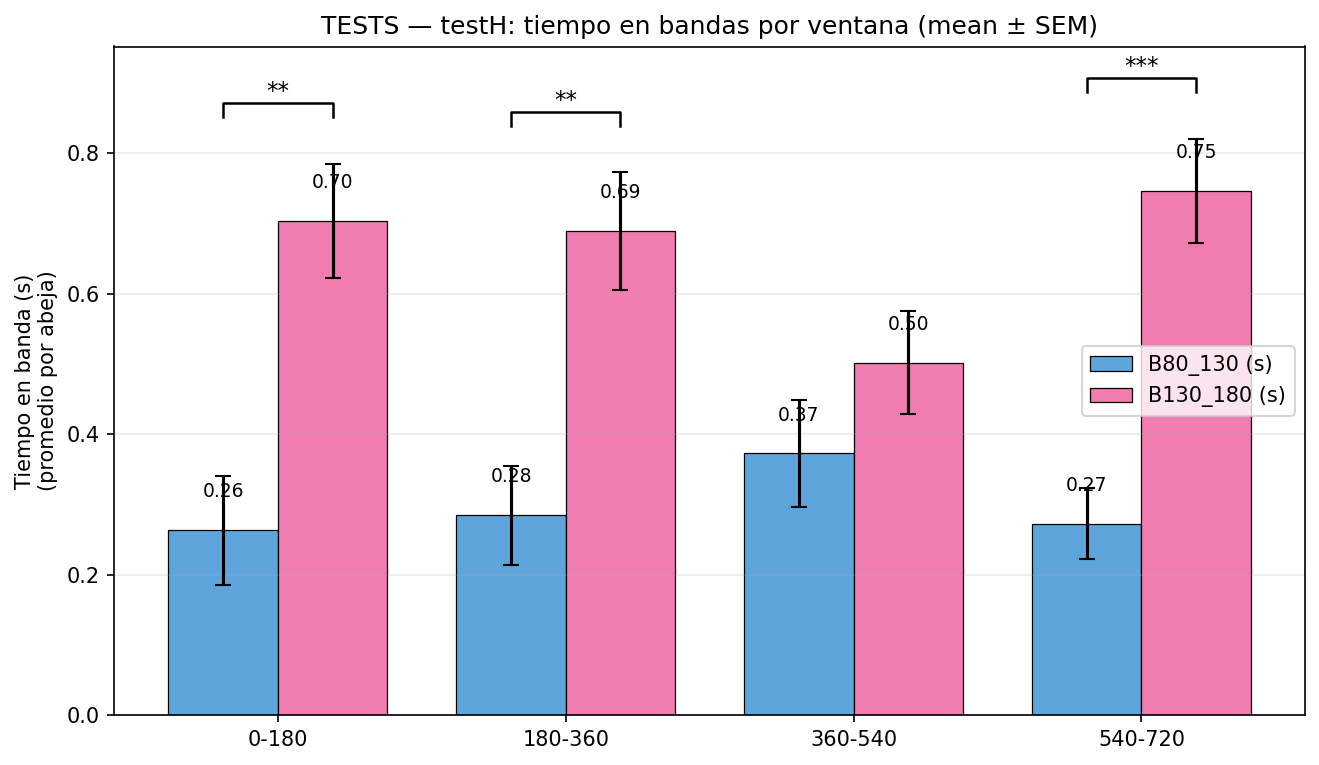

In [8]:
# -*- coding: utf-8 -*-
# Tiempo PROMEDIO por abeja en dos rangos de distancia al1–ar1:
#   - B80_130:  [80,130] px
#   - B130_180: (130,180] px
#
# Para cada archivo (abeja) y ventana: computa segundos en cada banda.
# Luego agrega por trial/test × ventana: mean ± SEM (por abeja).
# ESTADÍSTICA: dentro de CADA ventana, compara B80_130 vs B130_180
#   - Test pareado (Wilcoxon) entre bandas por abeja.
#   - Corrección de Holm por grupo (trial/test) a través de sus ventanas.
#   - Se anotan brackets y asteriscos en los barplots por grupo.
#
# Requiere: numpy, pandas, matplotlib, scipy

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# =================== Configuración ===================
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# Ventanas temporales (frames) [a, b)
WINDOWS = [(0, 180), (180, 360), (360, 540), (540, 720)]
WINDOW_LABELS = [f"{a}-{b}" for a, b in WINDOWS]

FPS = 60
USE_LIKELIHOOD = True
LIK_THR = 0.6

# Bandas de distancia (px)
BAND1_NAME = "B80_130"      # [80,130]
BAND2_NAME = "B130_180"     # (130,180]
BAND1_LOW, BAND1_HIGH = 80.0, 130.0
BAND2_LOW, BAND2_HIGH = 130.0, 180.0

# Estadística
ALPHA = 0.05
MIN_SUBJECTS_PAIRED = 5
P_THRESH = [(0.001, "***"), (0.01, "**"), (0.05, "*")]

# Exportar CSVs
SAVE_CSV = True
CSV_PER_FILE   = "al1_ar1_bandas_tiempo_por_archivo_mean.csv"
CSV_BY_GROUP   = "al1_ar1_bandas_tiempo_por_trialtest_mean.csv"
CSV_STATS      = "al1_ar1_bandas_stats_wilcoxon_holm.csv"

# =================== Utilidades ===================
def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

def get_series(df: pd.DataFrame, bp: str, coord: str) -> np.ndarray:
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")
    cols = df.columns
    names = cols.names
    try:
        idx_bp = names.index("bodyparts"); idx_coord = names.index("coords")
    except ValueError:
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)
    for c in cols:
        if idx_bp is not None and idx_coord is not None and len(c) > max(idx_bp, idx_coord):
            if (c[idx_bp] == bp) and (c[idx_coord] == coord):
                return df.loc[:, c].astype(float).to_numpy()
    raise KeyError(f"No hallé columnas para {bp}-{coord}")

NAME_RE = re.compile(r"^(?P<prefix>(?:trial|test)[^_]*)_", re.IGNORECASE)
def parse_group_and_animal(fname: str):
    stem = Path(fname).stem
    m = NAME_RE.match(stem)
    group = m.group("prefix") if m else stem
    an_m = re.search(r"(abeja\(\d+\))", fname, re.IGNORECASE)
    animal = an_m.group(1) if an_m else "abeja(?)"
    return group, animal

def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', str(s))]

def sem(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    return np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else np.nan

def holm_correction(pvals):
    p = np.array(pvals, dtype=float)
    m = len(p)
    order = np.argsort(p)  # asc
    adj = np.empty_like(p)
    for rank, idx in enumerate(order):
        adj[idx] = (m - rank) * p[idx]
    # Monotonicidad
    adj_sorted = np.minimum.accumulate(adj[order][::-1])[::-1]
    out = np.empty_like(p)
    out[order] = np.clip(adj_sorted, 0, 1)
    return out

def p_to_stars(p):
    for thr, stars in P_THRESH:
        if p <= thr:
            return stars
    return "ns"

def annotate_bracket(ax, x1, x2, y, text, h=0.02, lw=1.2, fs=11):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=fs)

# =================== Loop: tiempo en bandas por archivo × ventana ===================
rows_file = []

h5_files = sorted(FOLDER.glob("*.h5"), key=lambda p: natural_key(p.name))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        continue

    group, animal = parse_group_and_animal(h5.name)

    try:
        x_al1 = get_series(df, "al1", "x"); y_al1 = get_series(df, "al1", "y")
        x_ar1 = get_series(df, "ar1", "x"); y_ar1 = get_series(df, "ar1", "y")
        lk_al1 = get_series(df, "al1", "likelihood") if USE_LIKELIHOOD else None
        lk_ar1 = get_series(df, "ar1", "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[SKIP] {h5.name}: faltan al1/ar1 ({e})")
        continue

    n = min(len(x_al1), len(x_ar1))
    if n == 0:
        continue

    for (a, b), wlab in zip(WINDOWS, WINDOW_LABELS):
        aa = max(0, min(n, a)); bb = max(0, min(n, b))
        if bb - aa <= 0:
            continue

        valid = np.isfinite(x_al1[aa:bb]) & np.isfinite(y_al1[aa:bb]) \
              & np.isfinite(x_ar1[aa:bb]) & np.isfinite(y_ar1[aa:bb])
        if USE_LIKELIHOOD:
            if lk_al1 is not None: valid &= (lk_al1[aa:bb] > LIK_THR)
            if lk_ar1 is not None: valid &= (lk_ar1[aa:bb] > LIK_THR)
        if not np.any(valid):
            continue

        dx = x_al1[aa:bb] - x_ar1[aa:bb]
        dy = y_al1[aa:bb] - y_ar1[aa:bb]
        dist = np.hypot(dx, dy)

        d = dist[valid]

        # Bandas (sin solape en 130 px)
        in_b1 = (d >= BAND1_LOW) & (d <= BAND1_HIGH)    # [80, 130]
        in_b2 = (d >  BAND2_LOW) & (d <= BAND2_HIGH)    # (130, 180]

        fr_b1 = int(np.count_nonzero(in_b1))
        fr_b2 = int(np.count_nonzero(in_b2))

        sec_b1 = fr_b1 / float(FPS)
        sec_b2 = fr_b2 / float(FPS)

        rows_file.append({
            "file": h5.name,
            "trialtest": group,
            "animal": animal,
            "window": wlab,
            "n_frames_valid": int(np.count_nonzero(valid)),
            f"{BAND1_NAME}_frames": fr_b1,
            f"{BAND2_NAME}_frames": fr_b2,
            f"{BAND1_NAME}_seconds": sec_b1,
            f"{BAND2_NAME}_seconds": sec_b2,
        })

df_file = pd.DataFrame(rows_file)
if df_file.empty:
    raise SystemExit("No hay datos válidos para calcular tiempo en bandas de al1–ar1.")

# =================== Agregado por trial/test × ventana (PROMEDIO por abeja) ===================
band_frame_cols  = [f"{BAND1_NAME}_frames", f"{BAND2_NAME}_frames"]
band_second_cols = [f"{BAND1_NAME}_seconds", f"{BAND2_NAME}_seconds"]

# (1) Medias entre archivos/abejas
mean_dict = {c: "mean" for c in (band_frame_cols + band_second_cols)}
df_group_mean = (df_file
                 .groupby(["trialtest", "window"], as_index=False)
                 .agg(mean_dict))

# (2) n_archivos (conteo de abejas) por grupo
counts = (df_file
          .groupby(["trialtest", "window"])["file"]
          .nunique()
          .reset_index(name="n_archivos"))
df_group_mean = df_group_mean.merge(counts, on=["trialtest","window"], how="left")

# (3) SEM por abeja para segundos (para barras de error)
for c in band_second_cols:
    sem_col = c.replace("_seconds", "_seconds_sem")
    df_sem = (df_file.groupby(["trialtest","window"])[c]
                    .apply(lambda x: sem(x))
                    .reset_index(name=sem_col))
    df_group_mean = df_group_mean.merge(df_sem, on=["trialtest","window"], how="left")

# Orden natural
def _cat_sort(series):
    cats = sorted(series.unique(), key=natural_key)
    return pd.Categorical(series, categories=cats, ordered=True)

df_group_mean["trialtest"] = _cat_sort(df_group_mean["trialtest"])
df_group_mean["window"]    = pd.Categorical(df_group_mean["window"],
                                            categories=WINDOW_LABELS, ordered=True)
df_group_mean = df_group_mean.sort_values(["trialtest","window"])

print("\n=== Tiempo en bandas por archivo (segundos) — primeras filas ===")
print(df_file.head().to_string(index=False))
print(f"\nFilas (archivo×ventana): {len(df_file)}   Archivos únicos: {df_file['file'].nunique()}")

print("\n=== PROMEDIO por abeja (mean ± SEM) de tiempo en bandas por trial/test × ventana ===")
print(df_group_mean.to_string(index=False))

# =================== ESTADÍSTICA: Wilcoxon pareado B80_130 vs B130_180 por ventana ===================
stat_rows = []
for group_name in sorted(df_file["trialtest"].unique(), key=natural_key):
    # recolectar p-raw por ventanas para corrección de Holm dentro del grupo
    per_win = []
    for wlab in WINDOW_LABELS:
        sub = df_file[(df_file["trialtest"] == group_name) &
                      (df_file["window"] == wlab)]
        if sub.empty:
            continue
        pv = (sub[["animal", f"{BAND1_NAME}_seconds", f"{BAND2_NAME}_seconds"]]
              .groupby("animal").mean().dropna())
        if pv.empty or len(pv) < MIN_SUBJECTS_PAIRED:
            # sin datos suficientes
            stat_rows.append({
                "trialtest": group_name, "window": wlab,
                "n": int(len(pv)), "W": np.nan, "p_raw": np.nan,
                "p_holm": np.nan, "sig": False, "stars": "ns"
            })
            continue

        x = pv[f"{BAND1_NAME}_seconds"].to_numpy(float)
        y = pv[f"{BAND2_NAME}_seconds"].to_numpy(float)
        if np.allclose(x, y, equal_nan=False):
            W, p = 0.0, 1.0
        else:
            # pareado; ignora empates-cero
            W, p = wilcoxon(x, y, zero_method="wilcox", mode="approx")
        per_win.append((wlab, int(len(pv)), float(W), float(p)))

    # Corrección de Holm por las ventanas presentes del grupo
    if per_win:
        pvals = [t[3] for t in per_win]
        p_h = holm_correction(pvals)
        for (wlab, n, W, p_raw), p_corr in zip(per_win, p_h):
            stat_rows.append({
                "trialtest": group_name, "window": wlab,
                "n": n, "W": W, "p_raw": p_raw,
                "p_holm": float(p_corr),
                "sig": bool(p_corr < ALPHA),
                "stars": p_to_stars(p_corr)
            })

df_stats = pd.DataFrame(stat_rows)
if not df_stats.empty:
    df_stats["trialtest"] = _cat_sort(df_stats["trialtest"])
    df_stats["window"]    = pd.Categorical(df_stats["window"],
                                           categories=WINDOW_LABELS, ordered=True)
    df_stats = df_stats.sort_values(["trialtest","window"])
    print("\n=== Wilcoxon pareado (B80_130 vs B130_180) por ventana — Holm por grupo ===")
    print(df_stats.to_string(index=False))
else:
    print("\n[STATS] No hubo suficientes datos para pruebas pareadas.")

# =================== CSVs ===================
if SAVE_CSV:
    df_file.to_csv(CSV_PER_FILE, index=False)
    df_group_mean.to_csv(CSV_BY_GROUP, index=False)
    if not df_stats.empty:
        df_stats.to_csv(CSV_STATS, index=False)
    print(f"\nCSV exportados: {CSV_PER_FILE}, {CSV_BY_GROUP}" + (f", {CSV_STATS}" if not df_stats.empty else ""))

# =================== Gráficos — Barras por grupo (TRIALS y TESTS) con significancia ===================
def plot_category(df_group_mean: pd.DataFrame, df_stats: pd.DataFrame, prefix: str, title_tag: str):
    mask = df_group_mean["trialtest"].astype(str).str.lower().str.startswith(prefix)
    sub = df_group_mean[mask]
    if sub.empty:
        return

    ordered_groups = [g for g in df_group_mean["trialtest"].cat.categories
                      if str(g).lower().startswith(prefix)]

    col_b1 = "#5DA5DA"  # azul
    col_b2 = "#F17CB0"  # magenta
    w = 0.38

    for g in ordered_groups:
        sg = sub[sub["trialtest"] == g].sort_values("window")
        if sg.empty:
            continue

        x = np.arange(len(WINDOW_LABELS))

        means_b1 = sg[f"{BAND1_NAME}_seconds"].to_numpy(float)
        sem_b1   = sg[f"{BAND1_NAME}_seconds_sem"].to_numpy(float)

        means_b2 = sg[f"{BAND2_NAME}_seconds"].to_numpy(float)
        sem_b2   = sg[f"{BAND2_NAME}_seconds_sem"].to_numpy(float)

        fig_w = max(6.5, 1.6 * len(WINDOW_LABELS) + 2.5)
        fig, ax = plt.subplots(figsize=(fig_w, 5.2), dpi=150)

        ax.bar(x - w/2, means_b1, width=w, yerr=sem_b1, capsize=4,
               color=col_b1, edgecolor="black", linewidth=0.6, label=f"{BAND1_NAME} (s)")
        ax.bar(x + w/2, means_b2, width=w, yerr=sem_b2, capsize=4,
               color=col_b2, edgecolor="black", linewidth=0.6, label=f"{BAND2_NAME} (s)")

        ymax = np.nanmax([
            np.nanmax(means_b1 + np.nan_to_num(sem_b1, nan=0.0)) if len(means_b1) else 0,
            np.nanmax(means_b2 + np.nan_to_num(sem_b2, nan=0.0)) if len(means_b2) else 0
        ])
        # etiquetas de valor
        off = 0.05*ymax if np.isfinite(ymax) and ymax > 0 else 0.05
        for xi, m in zip(x - w/2, means_b1):
            if np.isfinite(m):
                ax.text(xi, m + off, f"{m:.2f}", ha="center", va="bottom", fontsize=9)
        for xi, m in zip(x + w/2, means_b2):
            if np.isfinite(m):
                ax.text(xi, m + off, f"{m:.2f}", ha="center", va="bottom", fontsize=9)

        ax.set_xticks(x, WINDOW_LABELS)
        ax.set_ylabel("Tiempo en banda (s)\n(promedio por abeja)")
        ax.set_title(f"{title_tag} — {g}: tiempo en bandas por ventana (mean ± SEM)")
        ax.grid(axis="y", alpha=0.25)
        ax.legend()

        # ===== Significancia por ventana (B80_130 vs B130_180) =====
        if not df_stats.empty:
            sstat = df_stats[df_stats["trialtest"] == g]
            # mapa ventana -> índice x
            idx_map = {wl: i for i, wl in enumerate(WINDOW_LABELS)}
            for _, row in sstat.iterrows():
                wl = row["window"]
                if wl not in idx_map or not bool(row.get("sig", False)):
                    continue
                i = idx_map[wl]
                # altura encima de la barra más alta del par en esa ventana
                top_i = np.nanmax([
                    means_b1[i] + (sem_b1[i] if np.isfinite(sem_b1[i]) else 0.0),
                    means_b2[i] + (sem_b2[i] if np.isfinite(sem_b2[i]) else 0.0)
                ])
                y = top_i + (0.08*ymax if np.isfinite(ymax) and ymax>0 else 0.08)
                annotate_bracket(ax, i - w/2, i + w/2, y, row["stars"])

        plt.tight_layout()
        plt.show()

# TRIALS
plot_category(df_group_mean, df_stats, prefix="trial", title_tag="TRIALS")
# TESTS
plot_category(df_group_mean, df_stats, prefix="test",  title_tag="TESTS")



=== Velocidad promedio por archivo (v_mean por ventana) ===
              file trialtest   animal  window  n_steps_used    v_mean     v_std   units
testA+_abeja(1).h5    testA+ abeja(1)   0-180            90 56.657620 32.936624 bases/s
testA+_abeja(1).h5    testA+ abeja(1) 180-360           149 47.942089 24.987830 bases/s
testA+_abeja(1).h5    testA+ abeja(1) 360-540           140 53.718702 30.563053 bases/s
testA+_abeja(1).h5    testA+ abeja(1) 540-720           114 82.618042 42.897046 bases/s
testA+_abeja(2).h5    testA+ abeja(2)   0-180            93 45.361198 26.482585 bases/s

Filas: 196   Archivos únicos: 49

=== Agregado por trial/test y ventana (media de v_mean ± SEM) ===
trialtest  window   units  v_mean_mean  v_mean_sem  n_archivos
   testA+   0-180 bases/s    48.032055    3.295915          24
   testA+ 180-360 bases/s    47.578047    3.640492          24
   testA+ 360-540 bases/s    55.681750    4.257705          24
   testA+ 540-720 bases/s    59.050025    4.106288        

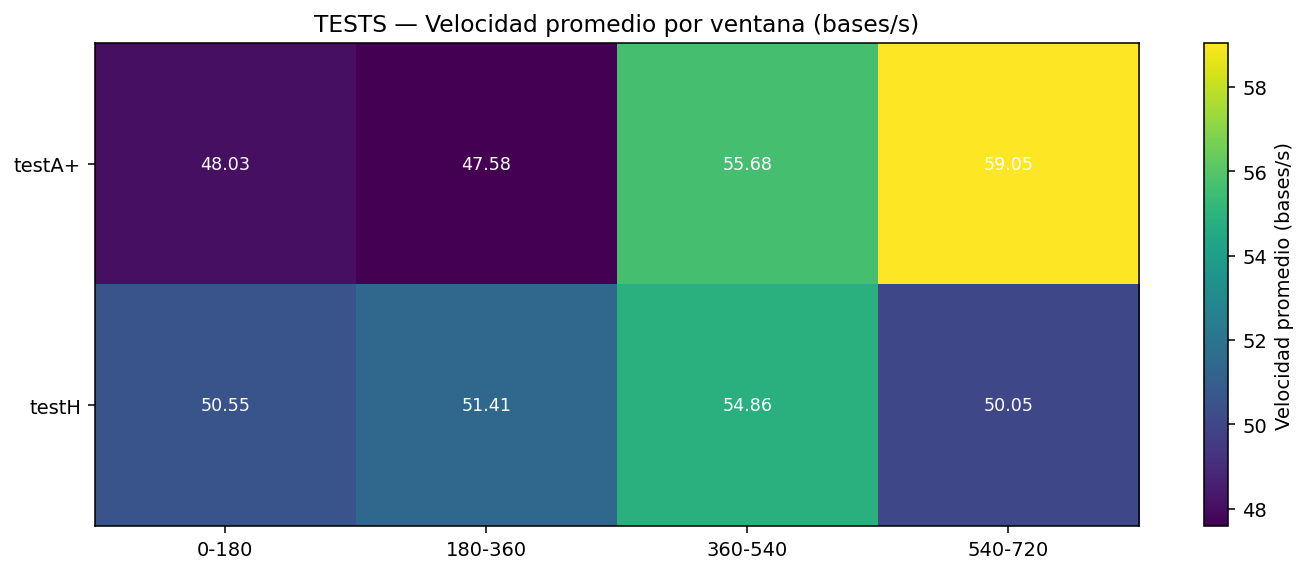

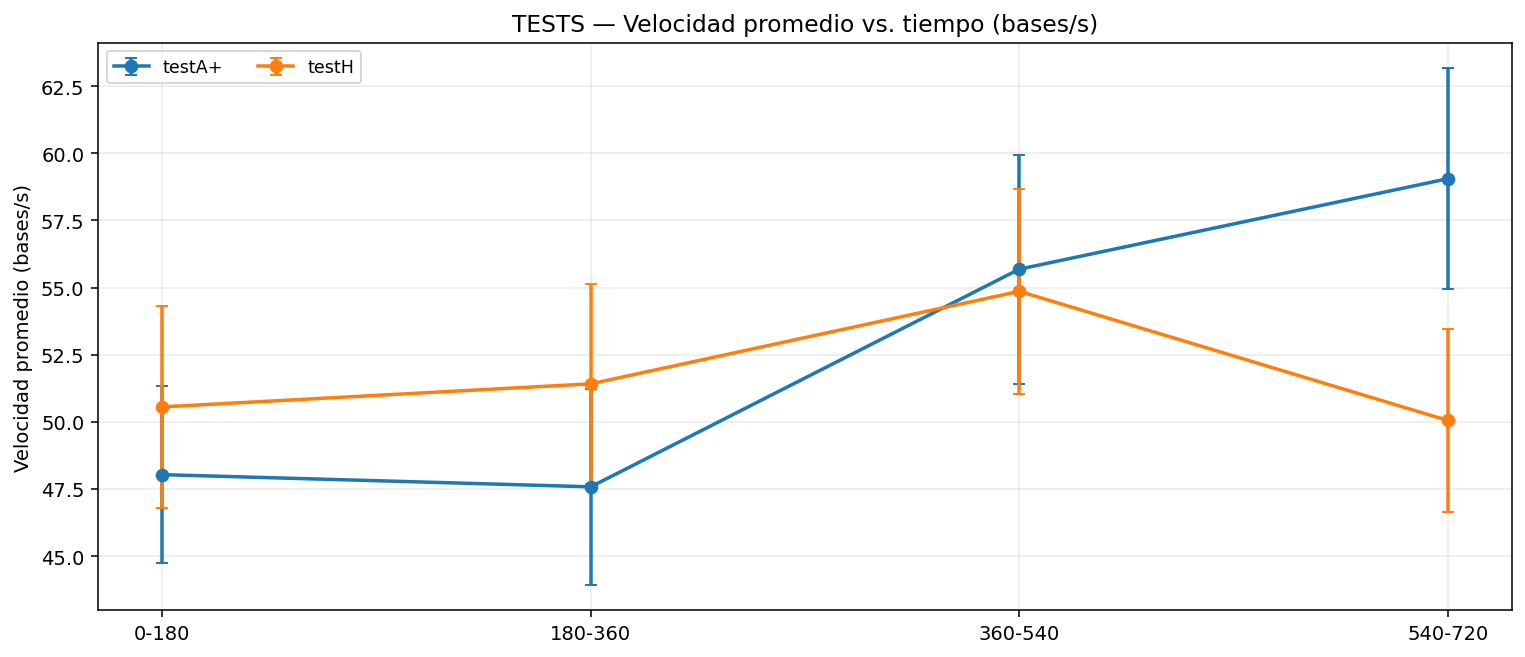


=== [TESTS · bases/s] Wilcoxon pareado entre ventanas (Holm) por TEST ===
  units   test   win_a   win_b     W  n    p_raw   p_holm   sig stars
bases/s testA+   0-180 180-360 136.0 24 0.689157 0.689157 False    ns
bases/s testA+   0-180 360-540  95.0 24 0.116083 0.348249 False    ns
bases/s testA+   0-180 540-720  30.0 24 0.000607 0.003641  True    **
bases/s testA+ 180-360 360-540  95.0 24 0.116083 0.348249 False    ns
bases/s testA+ 180-360 540-720  37.0 24 0.001244 0.006221  True    **
bases/s testA+ 360-540 540-720 124.0 24 0.457568 0.689157 False    ns
bases/s  testH   0-180 180-360 162.0 25 0.989266 0.989266 False    ns
bases/s  testH   0-180 360-540 120.0 25 0.252813 0.900724 False    ns
bases/s  testH   0-180 540-720 149.0 25 0.716423 0.989266 False    ns
bases/s  testH 180-360 360-540 115.0 25 0.201222 0.900724 False    ns
bases/s  testH 180-360 540-720 124.0 25 0.300241 0.900724 False    ns
bases/s  testH 360-540 540-720  88.0 25 0.045010 0.270057 False    ns
CSV exportado: 

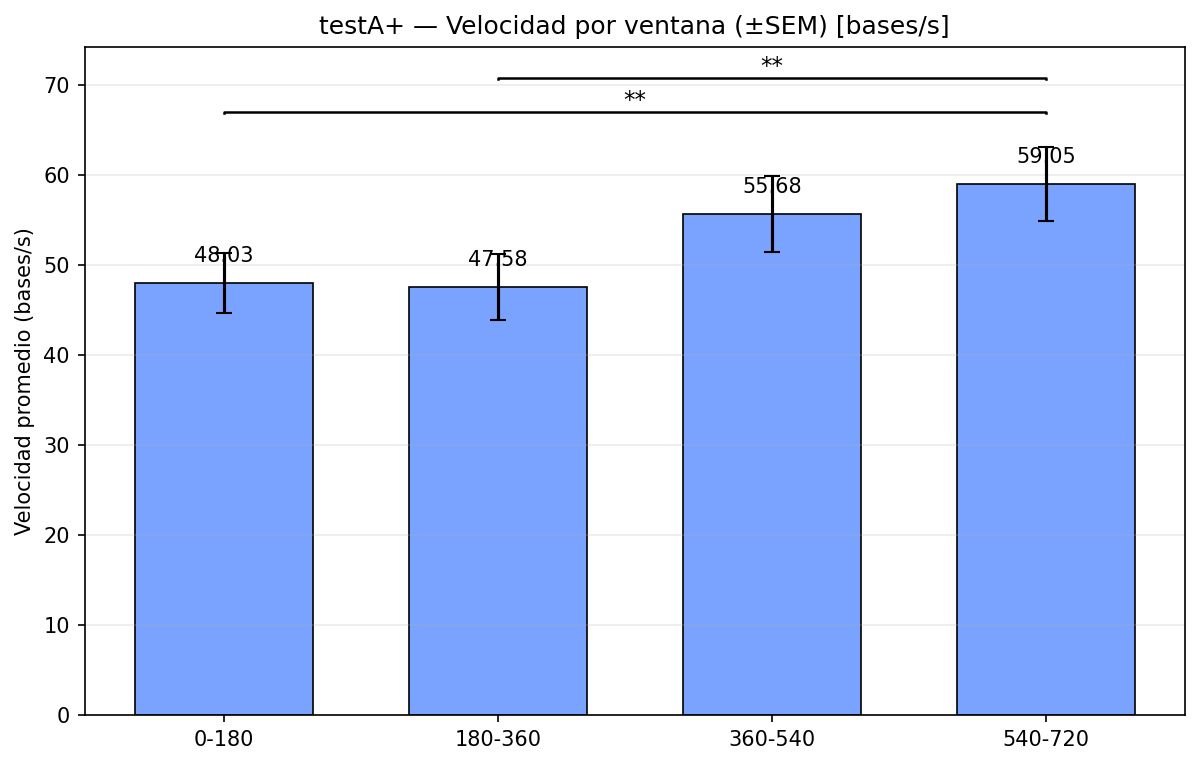

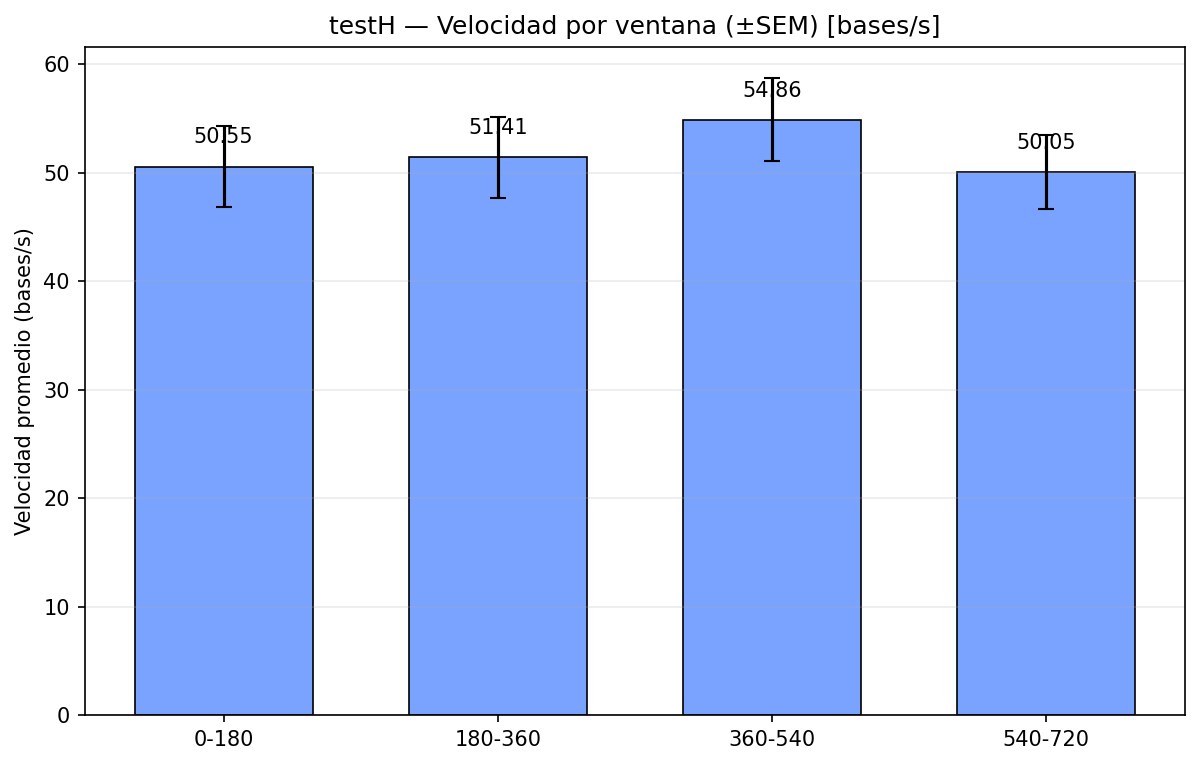

In [9]:
# -*- coding: utf-8 -*-
# Velocidad promedio entre antenas (al1 y ar1) por ventana temporal.
# 1) Para cada archivo: v_al1 = ||Δx,Δy||, v_ar1 = ||Δx,Δy||  -> v_mean = (v_al1 + v_ar1)/2
# 2) Promedio de v_mean en cada ventana -> una fila por archivo/ventana
# 3) Agregado por trial/test y ventana: media ± SEM
# 4) Exporta CSVs y grafica (heatmap + líneas) SEPARADO en TRIALS y TESTS
# 5) *** NUEVO ***: Estadística SOLO para TESTS (Wilcoxon pareado entre ventanas por test, Holm) + barplots con significancia

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import wilcoxon

# =================== Configuración ===================
FOLDER = Path(r"C:\Users\agust\OneDrive\Desktop notebook casa\videos test paper")

# Ventanas temporales (frames) [a, b)
#WINDOWS = [(270, 360), (360, 450), (450, 540), (540, 630)]
WINDOWS = [(0, 180), (180, 360), (360, 540), (540, 720)]
WINDOW_LABELS = [f"{a}-{b}" for a, b in WINDOWS]

# Señal y unidades
FPS = 60                              # para convertir a px/s
SPEED_UNITS = "px/s"                  # "px/s" o "px/frame"
SMOOTH_WIN = 0                        # 0 = sin suavizado; >1 = media móvil sobre la serie de v_mean

# Filtrado por likelihood
USE_LIKELIHOOD = True
LIK_THR = 0.6

# Normalizar velocidad por la distancia base al3–ar3
NORMALIZE_BY_BASE = True              # True -> velocidad en "bases/seg" o "bases/frame"
MIN_BASE_PX = 5.0

# Exportar CSVs
SAVE_CSV = True
CSV_PER_FILE = "velocidad_promedio_por_archivo.csv"
CSV_BY_GROUP = "velocidad_promedio_por_trialtest.csv"

# ===== Estadística (solo TESTS) =====
ALPHA = 0.05
MIN_SUBJECTS_PAIRED = 5   # mínimo de abejas en común por par de ventanas
P_THRESH = [(0.001, "***"), (0.01, "**"), (0.05, "*")]  # mapeo p→asteriscos

# =================== Utilidades ===================
def read_dlc_h5(h5_path: Path) -> pd.DataFrame:
    for key in ["df_with_missing", "pose", "data", None]:
        try:
            return pd.read_hdf(h5_path, key=key) if key is not None else pd.read_hdf(h5_path)
        except Exception:
            continue
    raise RuntimeError(f"No pude leer {h5_path}")

def get_series(df: pd.DataFrame, bp: str, coord: str) -> np.ndarray:
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("El H5 no tiene columnas MultiIndex (formato DLC).")
    cols = df.columns
    names = cols.names
    try:
        idx_bp = names.index("bodyparts"); idx_coord = names.index("coords")
    except ValueError:
        idx_bp, idx_coord = (1, 2) if len(names) >= 3 else (None, None)
    for c in cols:
        if idx_bp is not None and idx_coord is not None and len(c) > max(idx_bp, idx_coord):
            if (c[idx_bp] == bp) and (c[idx_coord] == coord):
                return df.loc[:, c].astype(float).to_numpy()
    raise KeyError(f"No hallé columnas para {bp}-{coord}")

# trialX/testY al comienzo del nombre
NAME_RE = re.compile(r"^(?P<prefix>(?:trial|test)[^_]*)_", re.IGNORECASE)
def parse_group_and_animal(fname: str):
    stem = Path(fname).stem
    m = NAME_RE.match(stem)
    group = m.group("prefix") if m else stem
    an_m = re.search(r"(abeja\(\d+\))", fname, re.IGNORECASE)
    animal = an_m.group(1) if an_m else "abeja(?)"
    return group, animal

def natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', str(s))]

def sem(x):
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    return np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else np.nan

def moving_average(a, k):
    if k is None or k <= 1:
        return a
    k = int(k)
    if k > a.size:
        return np.full_like(a, np.nan, dtype=float)
    c = np.cumsum(np.insert(a, 0, 0.0))
    out = (c[k:] - c[:-k]) / float(k)
    pad = (a.size - out.size)
    if pad > 0:
        left = pad//2
        right = pad - left
        out = np.concatenate([np.full(left, np.nan), out, np.full(right, np.nan)])
    return out

def holm_correction(pvals):
    """Holm-Bonferroni para array de p-valores."""
    p = np.array(pvals, dtype=float)
    m = len(p)
    order = np.argsort(p)  # ascendente
    adj = np.empty_like(p)
    for rank, idx in enumerate(order):
        adj[idx] = (m - rank) * p[idx]
    # monotónica no-decreciente
    adj_sorted = np.minimum.accumulate(adj[order][::-1])[::-1]
    out = np.empty_like(p)
    out[order] = np.clip(adj_sorted, 0, 1)
    return out

def p_to_stars(p):
    for thr, stars in P_THRESH:
        if p <= thr:
            return stars
    return "ns"

def annotate_bracket(ax, x1, x2, y, text, h=0.02, lw=1.2, fs=11):
    """Dibuja un bracket de significancia entre barras x1 y x2 a altura y."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=fs)

# =================== Loop: velocidad promedio entre antenas ===================
rows_file = []  # una fila por archivo y por ventana

h5_files = sorted(FOLDER.glob("*.h5"), key=lambda p: natural_key(p.name))
if not h5_files:
    raise SystemExit(f"No encontré .h5 en {FOLDER}")

for h5 in h5_files:
    try:
        df = read_dlc_h5(h5)
    except Exception as e:
        print(f"[SKIP] {h5.name}: {e}")
        continue

    group, animal = parse_group_and_animal(h5.name)

    try:
        x_al1 = get_series(df, "al1", "x"); y_al1 = get_series(df, "al1", "y")
        x_ar1 = get_series(df, "ar1", "x"); y_ar1 = get_series(df, "ar1", "y")
        lk_al1 = get_series(df, "al1", "likelihood") if USE_LIKELIHOOD else None
        lk_ar1 = get_series(df, "ar1", "likelihood") if USE_LIKELIHOOD else None
    except Exception as e:
        print(f"[SKIP] {h5.name}: faltan al1/ar1 ({e})")
        continue

    # Base para normalizar velocidad (opcional por archivo)
    normalize_this = NORMALIZE_BY_BASE
    if normalize_this:
        try:
            x_al3 = get_series(df, "al3", "x"); y_al3 = get_series(df, "al3", "y")
            x_ar3 = get_series(df, "ar3", "x"); y_ar3 = get_series(df, "ar3", "y")
            lk_al3 = get_series(df, "al3", "likelihood") if USE_LIKELIHOOD else None
            lk_ar3 = get_series(df, "ar3", "likelihood") if USE_LIKELIHOOD else None
        except Exception as e:
            print(f"[WARN] {h5.name}: no puedo normalizar (faltan al3/ar3). Sigo en píxeles.")
            normalize_this = False

    n = min(len(x_al1), len(x_ar1))
    if n < 2:
        continue

    for (a, b), wlab in zip(WINDOWS, WINDOW_LABELS):
        aa = max(0, min(n, a)); bb = max(0, min(n, b))
        if bb - aa <= 1:
            continue

        sl_prev = slice(aa, bb-1)
        sl_curr = slice(aa+1, bb)

        valid_prev = np.isfinite(x_al1[sl_prev]) & np.isfinite(y_al1[sl_prev]) \
                   & np.isfinite(x_ar1[sl_prev]) & np.isfinite(y_ar1[sl_prev])
        valid_curr = np.isfinite(x_al1[sl_curr]) & np.isfinite(y_al1[sl_curr]) \
                   & np.isfinite(x_ar1[sl_curr]) & np.isfinite(y_ar1[sl_curr])
        valid = valid_prev & valid_curr

        if USE_LIKELIHOOD:
            if lk_al1 is not None: valid &= (lk_al1[sl_prev] > LIK_THR) & (lk_al1[sl_curr] > LIK_THR)
            if lk_ar1 is not None: valid &= (lk_ar1[sl_prev] > LIK_THR) & (lk_ar1[sl_curr] > LIK_THR)

        if not np.any(valid):
            continue

        dx_al1 = x_al1[sl_curr] - x_al1[sl_prev]
        dy_al1 = y_al1[sl_curr] - y_al1[sl_prev]
        dx_ar1 = x_ar1[sl_curr] - x_ar1[sl_prev]
        dy_ar1 = y_ar1[sl_curr] - y_ar1[sl_prev]

        v_al1 = np.hypot(dx_al1, dy_al1)
        v_ar1 = np.hypot(dx_ar1, dy_ar1)

        if SPEED_UNITS.lower() == "px/s":
            v_al1 = v_al1 * FPS
            v_ar1 = v_ar1 * FPS

        if normalize_this:
            base_dx = x_al3[sl_curr] - x_ar3[sl_curr]
            base_dy = y_al3[sl_curr] - y_ar3[sl_curr]
            base_px = np.hypot(base_dx, base_dy)
            vb = np.isfinite(base_px) & (base_px >= MIN_BASE_PX)
            if USE_LIKELIHOOD and (lk_al3 is not None) and (lk_ar3 is not None):
                vb &= (lk_al3[sl_curr] > LIK_THR) & (lk_ar3[sl_curr] > LIK_THR)
            valid &= vb
            if not np.any(valid):
                continue
            v_al1 = v_al1[valid] / base_px[valid]
            v_ar1 = v_ar1[valid] / base_px[valid]
        else:
            v_al1 = v_al1[valid]
            v_ar1 = v_ar1[valid]

        v_mean = np.nanmean(np.vstack([v_al1, v_ar1]), axis=0)
        if SMOOTH_WIN and SMOOTH_WIN > 1:
            v_mean = moving_average(v_mean, SMOOTH_WIN)

        v_mean = v_mean[np.isfinite(v_mean)]
        if v_mean.size == 0:
            continue

        rows_file.append({
            "file": h5.name,
            "trialtest": group,
            "animal": animal,
            "window": wlab,
            "n_steps_used": int(v_mean.size),
            "v_mean": float(np.nanmean(v_mean)),
            "v_std": float(np.nanstd(v_mean, ddof=1)) if v_mean.size > 1 else np.nan,
            "units": f"{'bases' if normalize_this else 'px'}/{ 's' if SPEED_UNITS.lower()=='px/s' else 'frame'}"
        })

df_file = pd.DataFrame(rows_file)
if df_file.empty:
    raise SystemExit("No hay datos válidos para calcular velocidades.")

# =================== Agregado por trial/test y ventana ===================
df_group = (df_file
            .groupby(["trialtest","window","units"], as_index=False)
            .agg(v_mean_mean=("v_mean","mean"),
                 v_mean_sem =("v_mean", lambda x: sem(x)),
                 n_archivos=("v_mean","count")))

# Orden natural
df_group["trialtest"] = pd.Categorical(df_group["trialtest"],
                                       categories=sorted(df_group["trialtest"].unique(), key=natural_key),
                                       ordered=True)
df_group["window"] = pd.Categorical(df_group["window"],
                                    categories=WINDOW_LABELS, ordered=True)
df_group = df_group.sort_values(["trialtest","window"])

print("\n=== Velocidad promedio por archivo (v_mean por ventana) ===")
print(df_file.head().to_string(index=False))
print(f"\nFilas: {len(df_file)}   Archivos únicos: {df_file['file'].nunique()}")

print("\n=== Agregado por trial/test y ventana (media de v_mean ± SEM) ===")
print(df_group.to_string(index=False))

# =================== CSVs ===================
if SAVE_CSV:
    df_file.to_csv(CSV_PER_FILE, index=False)
    df_group.to_csv(CSV_BY_GROUP, index=False)
    print(f"\nCSV exportados: {CSV_PER_FILE}, {CSV_BY_GROUP}")

# =================== Visualizaciones (SEPARADAS) ===================
def plot_category(sub_all_units: pd.DataFrame, units_label: str, prefix: str, title_tag: str):
    # Filtra por 'trial' o 'test'
    mask = sub_all_units["trialtest"].str.lower().str.startswith(prefix)
    sub = sub_all_units[mask]
    if sub.empty:
        return

    # Orden de filas según las categorías ya ordenadas
    ordered_groups = [g for g in df_group["trialtest"].cat.categories if str(g).lower().startswith(prefix)]
    # 1) Heatmap
    pv = sub.pivot(index="trialtest", columns="window", values="v_mean_mean").reindex(ordered_groups)
    fig_h = 0.6*max(1, len(pv.index)) + 3
    fig, ax = plt.subplots(figsize=(1.8*len(WINDOW_LABELS)+3, fig_h), dpi=140)
    im = ax.imshow(pv.values, aspect="auto")
    ax.set_xticks(np.arange(len(WINDOW_LABELS)), WINDOW_LABELS)
    ax.set_yticks(np.arange(len(pv.index)), pv.index)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f"Velocidad promedio ({units_label})")
    ax.set_title(f"{title_tag} — Velocidad promedio por ventana ({units_label})")
    for i in range(pv.shape[0]):
        for j in range(pv.shape[1]):
            v = pv.values[i, j]
            if np.isfinite(v):
                ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color="white")
    plt.tight_layout()
    plt.show()

    # 2) Curvas por grupo a lo largo de las ventanas
    groups = [g for g in ordered_groups if g in sub["trialtest"].unique()]
    fig_w = 2.0*len(WINDOW_LABELS)+3
    fig, ax = plt.subplots(figsize=(fig_w, 4.8), dpi=140)
    for g in groups:
        sub_g = sub[sub["trialtest"] == g].sort_values("window")
        ax.errorbar(np.arange(len(WINDOW_LABELS)),
                    sub_g["v_mean_mean"].to_numpy(float),
                    yerr=sub_g["v_mean_sem"].to_numpy(float),
                    marker="o", linewidth=1.8, capsize=3, label=g)
    ax.set_xticks(np.arange(len(WINDOW_LABELS)), WINDOW_LABELS)
    ax.set_ylabel(f"Velocidad promedio ({units_label})")
    ax.set_title(f"{title_tag} — Velocidad promedio vs. tiempo ({units_label})")
    ax.grid(True, alpha=0.25)
    ax.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

# Recorremos por unidades y, dentro, por categoría (TRIALS / TESTS)
for units, sub_units in df_group.groupby("units"):
    # Trials
    plot_category(sub_units, units_label=units, prefix="trial", title_tag="TRIALS")
    # Tests
    plot_category(sub_units, units_label=units, prefix="test", title_tag="TESTS")

# =================== ESTADÍSTICA + BARRAS CON SIGNIFICANCIA (SOLO TESTS) ===================
# Trabajamos en la tabla por archivo (df_file) para mantener el apareo por abeja.
df_tests = df_file[df_file["trialtest"].str.lower().str.startswith("test")].copy()
if df_tests.empty:
    print("\n[ESTADÍSTICA TESTS] No hay filas de tests.")
else:
    # Procesamos por UNIDADES para evitar mezclar px/s con bases/s
    all_stats = []
    for units, sub_u in df_tests.groupby("units"):
        test_names = sorted(sub_u["trialtest"].unique(), key=natural_key)

        # --- Estadística por test (Wilcoxon pareado entre ventanas, Holm) ---
        for tname in test_names:
            sub_t = sub_u[sub_u["trialtest"] == tname].copy()
            # Pivot animal x ventana
            pv = (sub_t[["animal","window","v_mean"]]
                  .dropna()
                  .pivot_table(index="animal", columns="window", values="v_mean", aggfunc="mean")
                  .reindex(columns=WINDOW_LABELS))

            raw_ps, idx_pairs, pairs_info = [], [], []
            valid_cols = [c for c in WINDOW_LABELS if c in pv.columns]
            for a, b in combinations(valid_cols, 2):
                both = pv[[a, b]].dropna()
                if len(both) >= MIN_SUBJECTS_PAIRED:
                    xa = both[a].to_numpy(float)
                    xb = both[b].to_numpy(float)
                    if np.allclose(xa, xb, equal_nan=False):
                        W, p = 0.0, 1.0
                    else:
                        W, p = wilcoxon(xa, xb, zero_method="wilcox", mode="approx")
                    raw_ps.append(p)
                    idx_pairs.append((a, b))
                    pairs_info.append((W, len(both)))

            if raw_ps:
                p_holm = holm_correction(raw_ps)
                for (a, b), (W, n), p_raw, p_adj in zip(idx_pairs, pairs_info, raw_ps, p_holm):
                    all_stats.append({
                        "units": units, "test": tname,
                        "win_a": a, "win_b": b,
                        "W": float(W), "n": int(n),
                        "p_raw": float(p_raw), "p_holm": float(p_adj),
                        "sig": bool(p_adj < ALPHA), "stars": p_to_stars(float(p_adj))
                    })

        df_sig = pd.DataFrame(all_stats)
        if not df_sig.empty:
            print(f"\n=== [TESTS · {units}] Wilcoxon pareado entre ventanas (Holm) por TEST ===")
            print(df_sig.to_string(index=False))
            if SAVE_CSV:
                out_name = f"velocidad_tests_significancia_wilcoxon_holm_{units.replace('/','_')}.csv"
                df_sig.to_csv(out_name, index=False)
                print(f"CSV exportado: {out_name}")
        else:
            print(f"\n[TESTS · {units}] Sin pares con n ≥ {MIN_SUBJECTS_PAIRED} para Wilcoxon.")

        # --- Barplots por TEST (media ± SEM) con brackets de significancia ---
        df_tests_group = df_group[(df_group["trialtest"].str.lower().str.startswith("test")) &
                                  (df_group["units"] == units)].copy()
        for tname in test_names:
            sub_g = df_tests_group[df_tests_group["trialtest"] == tname].sort_values("window")
            if sub_g.empty:
                continue

            means = sub_g["v_mean_mean"].to_numpy(float)
            errs  = sub_g["v_mean_sem"].to_numpy(float)
            labels = sub_g["window"].tolist()
            xs = np.arange(len(labels))

            fig_w = max(6.0, 1.4*len(labels) + 2.5)
            fig, ax = plt.subplots(figsize=(fig_w, 5.2), dpi=150)
            bars = ax.bar(xs, means, yerr=errs, capsize=4, width=0.65,
                          color="#7aa2ff", edgecolor="black", linewidth=0.8)
            ax.set_xticks(xs, labels)
            ax.set_ylabel(f"Velocidad promedio ({units})")
            ax.set_title(f"{tname} — Velocidad por ventana (±SEM) [{units}]")

            ymax = np.nanmax(means + np.nan_to_num(errs, nan=0.0))
            for x, m, e in zip(xs, means, errs):
                if np.isfinite(m):
                    ax.text(x, m + (ymax*0.03 if np.isfinite(ymax) and ymax>0 else 0.03),
                            f"{m:.2f}", ha="center", va="bottom", fontsize=10)

            # Brackets
            if 'df_sig' in locals() and not df_sig.empty:
                sub_sig = df_sig[(df_sig["test"] == tname) & (df_sig["units"] == units)]
                sub_sig = sub_sig[sub_sig["win_a"].isin(labels) & sub_sig["win_b"].isin(labels)]
                sub_sig = sub_sig.sort_values("p_holm")

                idx_map = {lab: i for i, lab in enumerate(labels)}
                base = ymax + (0.06*ymax if np.isfinite(ymax) and ymax>0 else 0.06)
                step = 0.06 * (ymax if np.isfinite(ymax) and ymax>0 else 1.0)
                level = 0
                for _, row in sub_sig.iterrows():
                    if not row["sig"]:
                        continue
                    x1, x2 = idx_map[row["win_a"]], idx_map[row["win_b"]]
                    lo, hi = min(x1, x2), max(x1, x2)
                    y = base + level*step
                    annotate_bracket(ax, lo, hi, y, row["stars"])
                    level += 1

            ax.grid(axis="y", alpha=0.25)
            plt.tight_layout()
            plt.show()
